In [23]:
#!/usr/bin/env python3
# inagler 25/06/24

import os
import re
import gc

import numpy as np
import pandas as pd
import xarray as xr

import cftime
import pop_tools  
import gsw

In [24]:
import time

import matplotlib.pyplot as plt
import glob

# Find longitudes

In [3]:
vvel_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL'
# List all TEMP files in the directory (you can limit this to three files for the test)
file_paths = sorted(glob.glob(os.path.join(vvel_dir, '*.nc')))

In [4]:
ds = xr.open_dataset(file_paths[0])

In [5]:
data=ds.VVEL.roll(nlon=-100).isel(time=0, z_t=0)

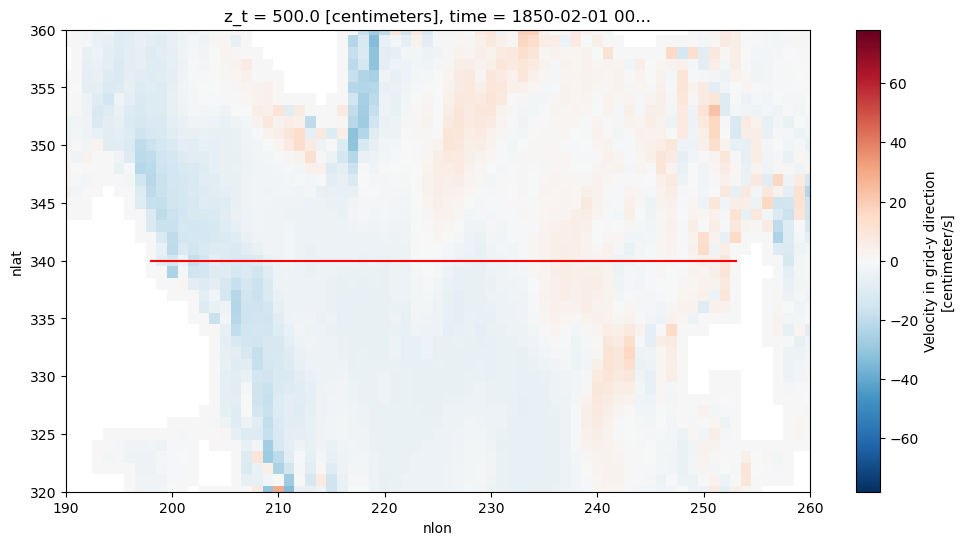

In [6]:
plt.figure(figsize=(12, 6))
data.plot()
plt.xlim(190, 260)
plt.ylim(320, 360)
plt.plot([198, 253], [340, 340], color='r', linestyle='-', label='y=5')
plt.show()

# Plan for faster code

- select latitude and longitude bounds run analysis without mask
```
sel_nlat = 340
sel_nlon = slice(198, 254)
```
- only compute smoc per file: select time periods
- combine at end


## select latitude and longitude bound

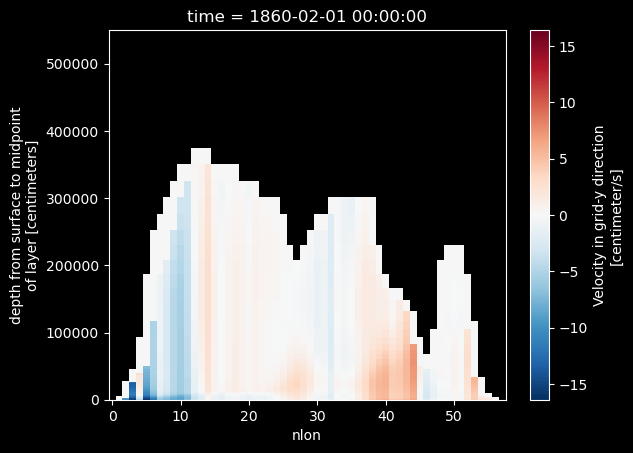

In [31]:
ds = xr.open_dataset(file_paths[1])
ds = ds.roll(nlon=-100)
ds = ds.isel(nlat=340, nlon=slice(197, 255))

plt.style.use('dark_background')

ds.VVEL.isel(time=0).plot()
plt.show()

##  select time periods

In [34]:

vvel_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL'
file_names = os.listdir(vvel_dir)

Time periods found for member 1281.009: []


In [36]:
# Specify the member you are interested in
member = "1281.009"

# Extract time periods for the specified member using list comprehension
time_periods = sorted({re.search(rf'LE2-{member}\.pop\.h\.VVEL\.(\d{{6}}-\d{{6}})\.nc', file).group(1)
                       for file in file_names if re.search(rf'LE2-{member}\.pop\.h\.VVEL\.(\d{{6}}-\d{{6}})\.nc', file)})


Time periods found for member 1281.009: ['185001-185912', '186001-186912', '187001-187912', '188001-188912', '189001-189912', '190001-190912', '191001-191912', '192001-192912', '193001-193912', '194001-194912', '195001-195912', '196001-196912', '197001-197912', '198001-198912', '199001-199912', '200001-200912', '201001-201412', '201501-202412', '202501-203412', '203501-204412', '204501-205412', '205501-206412', '206501-207412', '207501-208412', '208501-209412', '209501-210012']


In [56]:
# Directories for the variable folders
vvel_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL'
temp_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP'
salt_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/SALT'

# List of ensemble members and time periods
ensemble_members = [
    "1001.001", "1011.001", "1021.002", "1031.002", "1041.003",
    "1281.009", # Add other members as necessary
]
time_periods = [
    '185001-185912', '186001-186912', '187001-187912', '188001-188912',
    # Include other time periods...
    '209501-210012'
]

for member_id in ensemble_members:
    print(member_id, 'started')

    # Loop through each time period
    for time_period in time_periods:
        # Construct file patterns with time_period included
        vvel_pattern = os.path.join(vvel_dir, f'*{member_id}*{time_period}*.nc')
        temp_pattern = os.path.join(temp_dir, f'*{member_id}*{time_period}*.nc')
        salt_pattern = os.path.join(salt_dir, f'*{member_id}*{time_period}*.nc')

        print(glob.glob(vvel_pattern)[0])

        break
    break

1001.001 started
/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.VVEL.185001-185912.nc


## Test faster code

In [64]:
import psutil
import time

import os
import gc
import glob

import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da
import dask

import cftime
import pop_tools  
import gsw

start_time = time.time()

# compute density bins
numbers = np.array([29.70, 31.50, 33.15, 34.75, 35.80, 36.38, 36.70, 36.89, 37.06, 37.13, 37.30])
intervals = np.diff(numbers) / 4
result = np.concatenate([np.arange(numbers[i], numbers[i+1], intervals[i]) for i in range(len(intervals))])
density_bins = np.append(result, numbers[-1])

# define paths
vvel_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL'
temp_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP'
salt_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/SALT'
base_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'
output_dir = '/Data/skd/scratch/innag3580/comp/smoc/'

# define ensemble members
ensemble_members = [
    #"1001.001", "1011.001", "1021.002", "1031.002", "1041.003", "1051.003", "1061.004", "1071.004", "1081.005", "1091.005",
    #"1101.006", "1111.006", "1121.007", "1131.007", "1141.008", "1151.008", "1161.009", "1171.009", "1181.010", "1191.010",
    #"1231.001", "1231.002", "1231.003", "1231.004", "1231.005", "1231.006", "1231.007", "1231.008", "1231.009", "1231.010",
    #"1231.011", "1231.012", "1231.013", "1231.014", "1231.015", "1231.016", "1231.017", "1231.018", "1231.019", "1231.020",
    #"1251.001", "1251.002", "1251.003", "1251.004", "1251.005", "1251.006", "1251.007", "1251.008", "1251.009", "1251.010",
    #"1251.011", "1251.012", "1251.013", "1251.014", "1251.015", "1251.016", "1251.017", "1251.018", "1251.019", "1251.020",
    #"1281.001", "1281.002", "1281.003", "1281.004", "1281.005", "1281.006", "1281.007", "1281.008", "1281.009", "1281.010",
    #"1281.011", "1281.012", "1281.013", "1281.014", "1281.015", 
    "1281.016", "1281.017", "1281.018", "1281.019", "1281.020",
    "1301.001", "1301.002", "1301.003", "1301.004", "1301.005", "1301.006", "1301.007", "1301.008", "1301.009", "1301.010",
    "1301.011", "1301.012", "1301.013", "1301.014", "1301.015", "1301.016", "1301.017", "1301.018", "1301.019", "1301.020"
]

time_periods = ['185001-185912', '186001-186912', '187001-187912', '188001-188912', '189001-189912', '190001-190912', '191001-191912', '192001-192912', '193001-193912', '194001-194912', '195001-195912', '196001-196912', '197001-197912', '198001-198912', '199001-199912', '200001-200912', '201001-201412', '201501-202412', '202501-203412', '203501-204412', '204501-205412', '205501-206412', '206501-207412', '207501-208412', '208501-209412', '209501-210012']

# select latitude
sel_nlat = 340
sel_nlon = slice(198, 254)

def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def load_dataset(file):
    try:
        #ds = xr.open_dataset(file, chunks='auto') 
        ds = xr.open_dataset(file) 
        ds = ds.roll(nlon=-100)
        ds = ds.isel(nlat=sel_nlat, nlon=sel_nlon)
    except (RuntimeError, IndexError) as e:
        print(f"Loading failed for {file}: {str(e)}")
        return None
    return ds

def calculate_dens2(temp_ds, salt_ds):
    CT = gsw.conversions.CT_from_pt(salt_ds['SALT'], temp_ds['TEMP'])
    sigma2 = gsw.density.sigma2(salt_ds['SALT'], CT)
    sigma2 = sigma2.rename('SIGMA_2')
    return sigma2

def calculate_smoc55(ds_vvel, da_dens):
    
    max_overturning_series = []
    cell_thickness = ds_vvel['dz']
    cell_width = ds_vvel['DXU']
    
    for time_step in range(len(ds_vvel.time)):
        try:
            # compute meridional flow rate for the specified latitude
            velocity = ds_vvel['VVEL'].isel(time=time_step)
            flow_rate = velocity * cell_thickness * cell_width

            # compute meridional flow rate and for each density bin and integrate zonally
            density_at_time = da_dens.isel(time=time_step)
            flow_rate_by_density = np.zeros(len(density_bins))
            for bin_index in range(len(density_bins) - 1):
                in_bin = (density_at_time >= density_bins[bin_index]) & (density_at_time < density_bins[bin_index + 1])
                flow_rate_by_density[bin_index] = flow_rate.where(in_bin).sum()

            # compute density overturning, reverse to integrate from high to low density
            density_overturning = np.cumsum(flow_rate_by_density)[::-1]
            max_overturning = np.max(density_overturning)
            max_overturning_series.append(max_overturning)
            
        except IndexError as e:
            print(f"Error occurred at time step: {time_step}")
            raise e
    max_overturning_dataarray = xr.DataArray(max_overturning_series, dims=["time"], coords={"time": ds_vvel['time']})
    return max_overturning_dataarray  * 1e-12

def log_error(member_id, time_period, log_file='smoc55_error_log.txt'):
    with open(log_file, 'a') as f:
        f.write(f"{member_id} and {time_period}\n")
        
def log_memory_usage(log_file='memory_log.txt'):
    memory_info = psutil.virtual_memory()
    used_memory = memory_info.used / (1024 ** 2)  # Convert bytes to megabytes
    with open(log_file, 'a') as f:
        f.write(f"Memory Used: {used_memory:.2f} MB\n")
    return used_memory
        
def process_files(member_id, time_period):
    print(f'Starting processing for member: {member_id}, time period: {time_period}')

    try:
        vvel_pattern = os.path.join(vvel_dir, f'*{member_id}*{time_period}*.nc')
        temp_pattern = os.path.join(temp_dir, f'*{member_id}*{time_period}*.nc')
        salt_pattern = os.path.join(salt_dir, f'*{member_id}*{time_period}*.nc')

        temp_files = glob.glob(temp_pattern)
        salt_files = glob.glob(salt_pattern)
        vvel_files = glob.glob(vvel_pattern)

        if not temp_files or not salt_files or not vvel_files:
            print(f'Files not found for member {member_id} and period {time_period}.')
            return

        ds_temp = load_dataset(temp_files[0])
        if ds_temp is None: return
        print('ds_temp loaded')
        log_memory_usage()
        
        ds_salt = load_dataset(salt_files[0])
        if ds_salt is None: return
        print('ds_salt loaded')
        log_memory_usage()
        
        ds_vvel = load_dataset(vvel_files[0])
        if ds_vvel is None: return
        print('ds_vvel loaded')
        log_memory_usage()

        da_dens = calculate_dens2(ds_temp, ds_salt)
        da_dens.astype('float32')
        print('da_dens computed')
        log_memory_usage()

        da_smoc55 = calculate_smoc55(ds_vvel, da_dens)
        print('smoc55 computed')
        da_smoc55.to_netcdf(os.path.join(output_dir, f'smoc55_member_{member_id}_{time_period}.nc'))
        log_memory_usage()
        print(f'{member_id} - {time_period} saved')

        del ds_temp, ds_salt, ds_vvel, da_dens, da_smoc55
        gc.collect()

    except IndexError as e:
        print(f"Error occurred for member: {member_id}, time period: {time_period}")
        log_error(member_id, time_period)  # Assuming log_error_member is defined

# Using Dask to parallelize the processing
tasks = []
for member_id in ensemble_members:
    for time_period in time_periods:
        task = dask.delayed(process_files)(member_id, time_period)
        tasks.append(task)
        break
    break

# Compute all the delayed tasks in parallel
dask.compute(*tasks)

print('')
print('computation complete')
print('')
end_time = time.time()
duration = end_time - start_time
print(f"Execution time: {duration} seconds")

Starting processing for member: 1281.016, time period: 185001-185912


KeyboardInterrupt: 

ds_temp loaded
ds_salt loaded
ds_vvel loaded
da_dens computed
smoc55 computed
1281.016 - 185001-185912 saved


# check file format of produced density files

In [18]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/DENS2/'
dens_file = 'b.e21.BHISTcmip6.f09_g17.LE2-1281.009.pop.h.DENS2.186001-186912.nc'
dens_ds = xr.open_dataset(path+dens_file)

In [22]:
dens_ds.SIGMA_2.isel(nlat=340, nlon=0, time=0).values

array([36.41653359, 36.41634538, 36.4163769 , 36.41647717, 36.41660558,
       36.41674058, 36.41691914, 36.41714501, 36.41736983, 36.41759868,
       36.41780981, 36.41809381, 36.41850871, 36.42580845, 36.48045313,
       36.54425485, 36.59628495, 36.62910221, 36.64119328, 36.64449022,
       36.64574147, 36.6469625 , 36.64834127, 36.64974983, 36.65100347,
       36.65213748, 36.65321261, 36.65359573, 36.65437404, 36.65470876,
       36.65478429, 36.65523397, 36.65547772, 36.65569809, 36.65603408,
       36.65668416, 36.65727543, 36.65808941, 36.65973155, 36.66134921,
       36.66336127, 36.66572877, 36.66859469, 36.67376299, 36.68700985,
       36.71139935, 36.74447175, 36.77903431, 36.81025332, 36.83585355,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan])

In [27]:
test_ds = dens_ds.astype('float32')

In [28]:
test_ds.SIGMA_2.isel(nlat=340, nlon=0, time=0).values

array([36.416534, 36.416344, 36.416378, 36.416477, 36.416607, 36.41674 ,
       36.41692 , 36.417145, 36.41737 , 36.4176  , 36.41781 , 36.418095,
       36.41851 , 36.425808, 36.480453, 36.544254, 36.596287, 36.6291  ,
       36.641193, 36.64449 , 36.64574 , 36.64696 , 36.648342, 36.64975 ,
       36.651005, 36.652138, 36.653214, 36.653595, 36.654373, 36.65471 ,
       36.654785, 36.655235, 36.65548 , 36.655697, 36.656033, 36.656685,
       36.657276, 36.65809 , 36.659733, 36.66135 , 36.66336 , 36.66573 ,
       36.668594, 36.673763, 36.68701 , 36.7114  , 36.744473, 36.779034,
       36.810253, 36.835854,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan],
      dtype=float32)

# Prepare code for extracting data

In [12]:
# Define the base path and ensemble members
base_path = "/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/"
ensemble_members = [
    "1001.001", "1011.001", "1021.002", "1031.002", "1041.003", "1051.003", "1061.004", "1071.004", "1081.005", "1091.005",
    "1101.006", "1111.006", "1121.007", "1131.007", "1141.008", "1151.008", "1161.009", "1171.009", "1181.010", "1191.010",
    "1231.001", "1231.002", "1231.003", "1231.004", "1231.005", "1231.006", "1231.007", "1231.008", "1231.009", "1231.010",
    "1231.011", "1231.012", "1231.013", "1231.014", "1231.015", "1231.016", "1231.017", "1231.018", "1231.019", "1231.020",
    "1251.001", "1251.002", "1251.003", "1251.004", "1251.005", "1251.006", "1251.007", "1251.008", "1251.009", "1251.010",
    "1251.011", "1251.012", "1251.013", "1251.014", "1251.015", "1251.016", "1251.017", "1251.018", "1251.019", "1251.020",
    "1281.001", "1281.002", "1281.003", "1281.004", "1281.005", "1281.006", "1281.007", "1281.008", "1281.009", "1281.010",
    "1281.011", "1281.012", "1281.013", "1281.014", "1281.015", "1281.016", "1281.017", "1281.018", "1281.019", "1281.020",
    "1301.001", "1301.002", "1301.003", "1301.004", "1301.005", "1301.006", "1301.007", "1301.008", "1301.009", "1301.010",
    "1301.011", "1301.012", "1301.013", "1301.014", "1301.015", "1301.016", "1301.017", "1301.018", "1301.019", "1301.020"
]

# Define the variables
variables = ["TEMP", "SALT", "VVEL"]

In [ ]:
def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def load_and_process_dataset(file_paths, mask):
    # Open datasets
    datasets = [xr.open_dataset(file) for file in file_paths]

    # Concatenate datasets along the time dimension
    ds = xr.concat(datasets, dim='time')
    ds = standardise_time(ds)
    
    try:
        processed_dataset = ds.roll(nlon=-100).where(mask)
    except (RuntimeError, IndexError) as e:
        print(f"Initial processing failed, loading step-by-step: {str(e)}")
        processed_dataset = handle_deprecated_data(ds, mask)
    print('process check')
    return processed_dataset

In [14]:
for member_id in ensemble_members:
    file_paths = {}
    
    try:
        # Loop through each variable
        for variable in variables:
            # Construct the pattern and find matching files
            file_pattern = os.path.join(base_path, variable, f'*LE2-{member_id}*.nc')
            matching_files = glob.glob(file_pattern)

            # Store the matching files in the dictionary
            file_paths[variable] = matching_files

        # Process the datasets for TEMP, SALT, and VVEL
        ds_temp = load_and_process_dataset(file_paths['TEMP'], moc55_mask)
        ds_salt = load_and_process_dataset(file_paths['SALT'], moc55_mask)
        ds_vvel = load_and_process_dataset(file_paths['VVEL'], moc55_mask)



# Prepare code for Atlantic density overturning for CESM2 LENS2 members
- Load and process datasets for velocity, temperature, and salinity
- Define regional mask
- Calculate potential density and density overturning
- Save results to NetCDF files

In [3]:
numbers = np.array([29.70, 31.50, 33.15, 34.75, 35.80, 36.38, 36.70, 36.89, 37.06, 37.13, 37.30])
intervals = np.diff(numbers) / 4
result = np.concatenate([np.arange(numbers[i], numbers[i+1], intervals[i]) for i in range(len(intervals))])
density_bins = np.append(result, numbers[-1])

In [7]:
vvel_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL/'
#temp_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/'
#salt_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/SALT/'

vvel_file = 'b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.VVEL.185001-185912.nc'
#temp_file = 'b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.TEMP.185001-185912.nc'
#salt_file = 'b.e21.BHISTcmip6.f09_g17.LE2-1001.001.pop.h.SALT.185001-185912.nc'

In [8]:
sel_nlat = 340

In [9]:
ds = xr.load_dataset(vvel_dir+vvel_file)

In [10]:
vvel_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/vvel'
temp_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp'
salt_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/salt'
output_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp_2/smoc/'

In [15]:
# this is not the most elegant way, it would be better to just give the nlon range
grid_name = 'POP_gx1v7'
region_defs = {
    'subzero_Atlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [53.0, 58.0], 'TLONG': [260.0, 357.0]}}
    ],
    #'superzero_Atlantic':[
    #    {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [53.0, 58.0], 'TLONG': [0, 5.0]}}
    #],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [53.0, 58.0]}}
    ]
}
moc55_mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='Overtrunign at 55N Mask')
moc55_mask = moc55_mask.sum('region')
moc55_mask = moc55_mask.roll(nlon=-100)

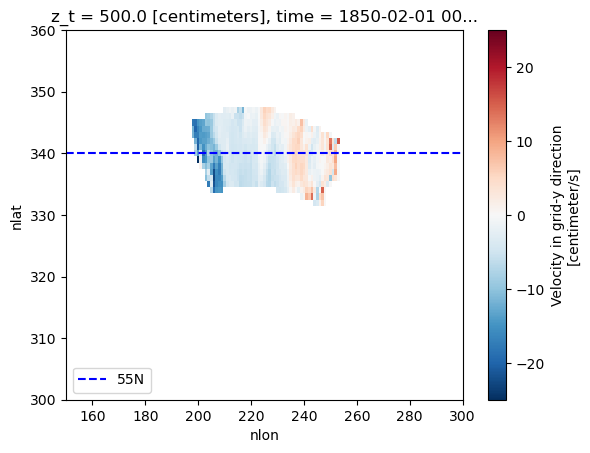

In [16]:
ds.VVEL.roll(nlon=-100).isel(time=0, z_t=0).where(moc55_mask).plot()
plt.axhline(y=sel_nlat, color='blue', linestyle='--', label='55N')
plt.legend(loc='lower left')
plt.xlim(150, 300)
plt.ylim(300, 360)
plt.show()

In [11]:
def extract_member_id(filename):
    match = re.search(r'vvel_([^.]+(?:\.\d+)?)\.nc', filename)
    return match.group(1) if match else None

def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def calculate_dens2(temp_ds, salt_ds, nlat):
    CT = gsw.conversions.CT_from_pt(salt_ds['SALT'].isel(nlat=nlat), temp_ds['TEMP'].isel(nlat=nlat))
    sigma2_at_latitude = gsw.density.sigma2(salt_ds['SALT'].isel(nlat=nlat), CT)
    sigma2_at_latitude = sigma2_at_latitude.rename('SIGMA_2')
    return sigma2_at_latitude

def load_and_process_dataset(file_path, mask):
    ds = xr.open_dataset(file_path, decode_times=False)
    ds = standardise_time(ds)
    try:
        processed_dataset = ds.roll(nlon=-100).where(mask)
    except (RuntimeError, IndexError) as e:
        print(f"Initial processing failed, loading step-by-step: {str(e)}")
        processed_dataset = handle_deprecated_data(ds, mask)
    print('process check')
    return processed_dataset

def handle_deprecated_data(ds, mask):
    total_time_steps = ds.dims['time']
    last_valid_data = None
    for t in range(total_time_steps):
        try:
            current_data = ds.isel(time=t).load()
            last_valid_data = current_data
        except RuntimeError as e:
            print(f"Error at timestep {t}: {str(e)}")
            if last_valid_data is not None:
                current_data = last_valid_data
            else:
                raise ValueError(f"No valid data at timestep {t}")
        if t == 0:
            combined_data = current_data
        else:
            combined_data = xr.concat([combined_data, current_data], dim='time')
    combined_data['time'] = np.arange(total_time_steps)
    result_dataset = combined_data.roll(nlon=-100).where(mask)
    return result_dataset



In [17]:
def calculate_smoc_55(ds_vvel, da_dens, latitude_index):
    
    #meridional_density = da_dens.mean(dim=['nlon'])
    
    max_overturning_series = []

    cell_thickness = ds_vvel['dz'].isel(nlat=latitude_index)
    cell_width = ds_vvel['DXU'].isel(nlat=latitude_index)
    
    for time_step in range(len(ds_vvel.time)):
        try:
            # compute meridional flow rate for the specified latitude
            velocity = ds_vvel['VVEL'].isel(time=time_step, nlat=latitude_index)
            flow_rate = velocity * cell_thickness * cell_width
            
            # compute density bins
            #density_at_time = meridional_density.isel(time=time_step)
            #densities = density_at_time.values
            #sorted_indices = np.argsort(densities)
            #density_bins = densities[sorted_indices]

            # compute meridional flow rate and for each density bin and integrate zonally
            density_at_time = da_dens.isel(time=time_step)
            flow_rate_by_density = np.zeros(len(density_bins))
            for bin_index in range(len(density_bins) - 1):
                in_bin = (density_at_time >= density_bins[bin_index]) & (density_at_time < density_bins[bin_index + 1])
                flow_rate_by_density[bin_index] = flow_rate.where(in_bin).sum()

            # compute density overturning, reverse to integrate from high to low density
            density_overturning = np.cumsum(flow_rate_by_density)[::-1]
            max_overturning = np.max(density_overturning)
            max_overturning_series.append(max_overturning)
        except IndexError as e:
            print(f"Error occurred at time step: {time_step}")
            raise e
    
    max_overturning_dataarray = xr.DataArray(max_overturning_series, dims=["time"], coords={"time": ds_vvel['time']})
    return density_bins, max_overturning_dataarray  * 1e-12

In [13]:
#vvel_path = vvel_dir+vvel_file
#temp_path = temp_dir+temp_file
#salt_path = salt_dir+salt_file

In [14]:
#ds_temp = load_and_process_dataset(temp_path, moc55_mask)
#ds_salt = load_and_process_dataset(salt_path, moc55_mask)

process check
process check


In [15]:
#da_dens = calculate_dens2(ds_temp, ds_salt, sel_nlat)
#ds_vvel = load_and_process_dataset(vvel_path, moc55_mask)

process check


In [18]:
#density_bins, max_overturning_dataarray = calculate_smoc_55(ds_vvel.isel(time=slice(0,3)), da_dens.isel(time=slice(0,3)), sel_nlat)

In [19]:
#max_overturning_dataarray

<xarray.DataArray (time: 3)>
array([17.86032427, 18.2275357 , 21.36297674])
Coordinates:
  * time     (time) datetime64[ns] 1850-02-01 1850-03-01 1850-04-01

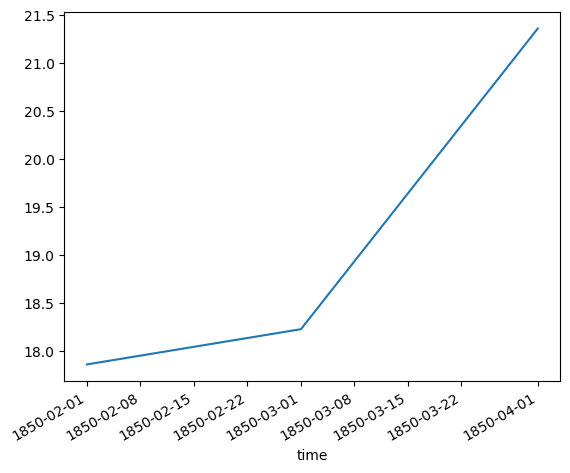

In [20]:
max_overturning_dataarray.plot()

In [24]:
total_members = len(os.listdir(temp_dir))
processed_count = 0

for file in os.listdir(vvel_dir):
    member_id = extract_member_id(file)
    vvel_path = os.path.join(vvel_dir, file)
    temp_path = os.path.join(temp_dir, f'temp_{member_id}.nc')
    salt_path = os.path.join(salt_dir, f'salt_{member_id}.nc')
 
    ds_temp = load_and_process_dataset(temp_path, moc55_mask)
    ds_salt = load_and_process_dataset(salt_path, moc55_mask)
    da_dens = calculate_sigma2(ds_temp, ds_salt, sel_nlat)
    ds_vvel = load_and_process_dataset(vvel_path, moc55_mask)
    
    density_bins, da_smoc55 = calculate_smoc_55(ds_vvel.isel(time=slice(0,3)), da_dens.isel(time=slice(0,3)), sel_nlat)
    #da_smoc55.to_netcdf(os.path.join(output_dir, f'monthly_smoc55_member_{member_id}.nc'))
    
    da_smoc55.plot()

    ds_temp.close()
    ds_salt.close()
    da_dens.close()
    ds_vvel.close()
    da_smoc55.close()

    del temp_ds, salt_ds, sigma_ds, vvel_ds, da_smoc55
    gc.collect()

process check
process check


NameError: name 'calculate_sigma2' is not defined

# CHECK OUPUT

## plot time series

In [87]:
output_dir = '/Data/skd/scratch/innag3580/comp/smoc/'
all_output = glob.glob(os.path.join(output_dir, '*.nc'))
len_final_files = len('smoc55_member_1001.001.nc')
output = [f for f in all_output if len(os.path.basename(f)) == len_final_files]


In [88]:
da = xr.load_dataarray(output[1])

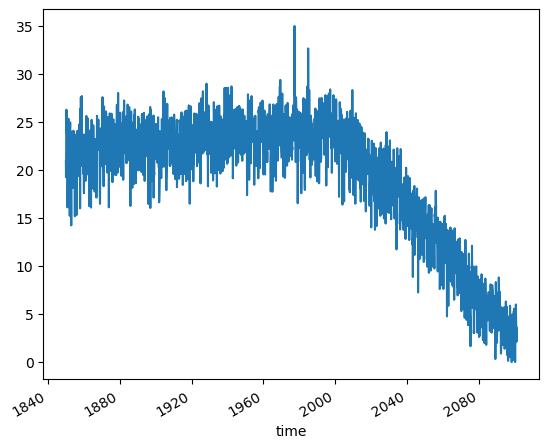

In [89]:
da.plot()

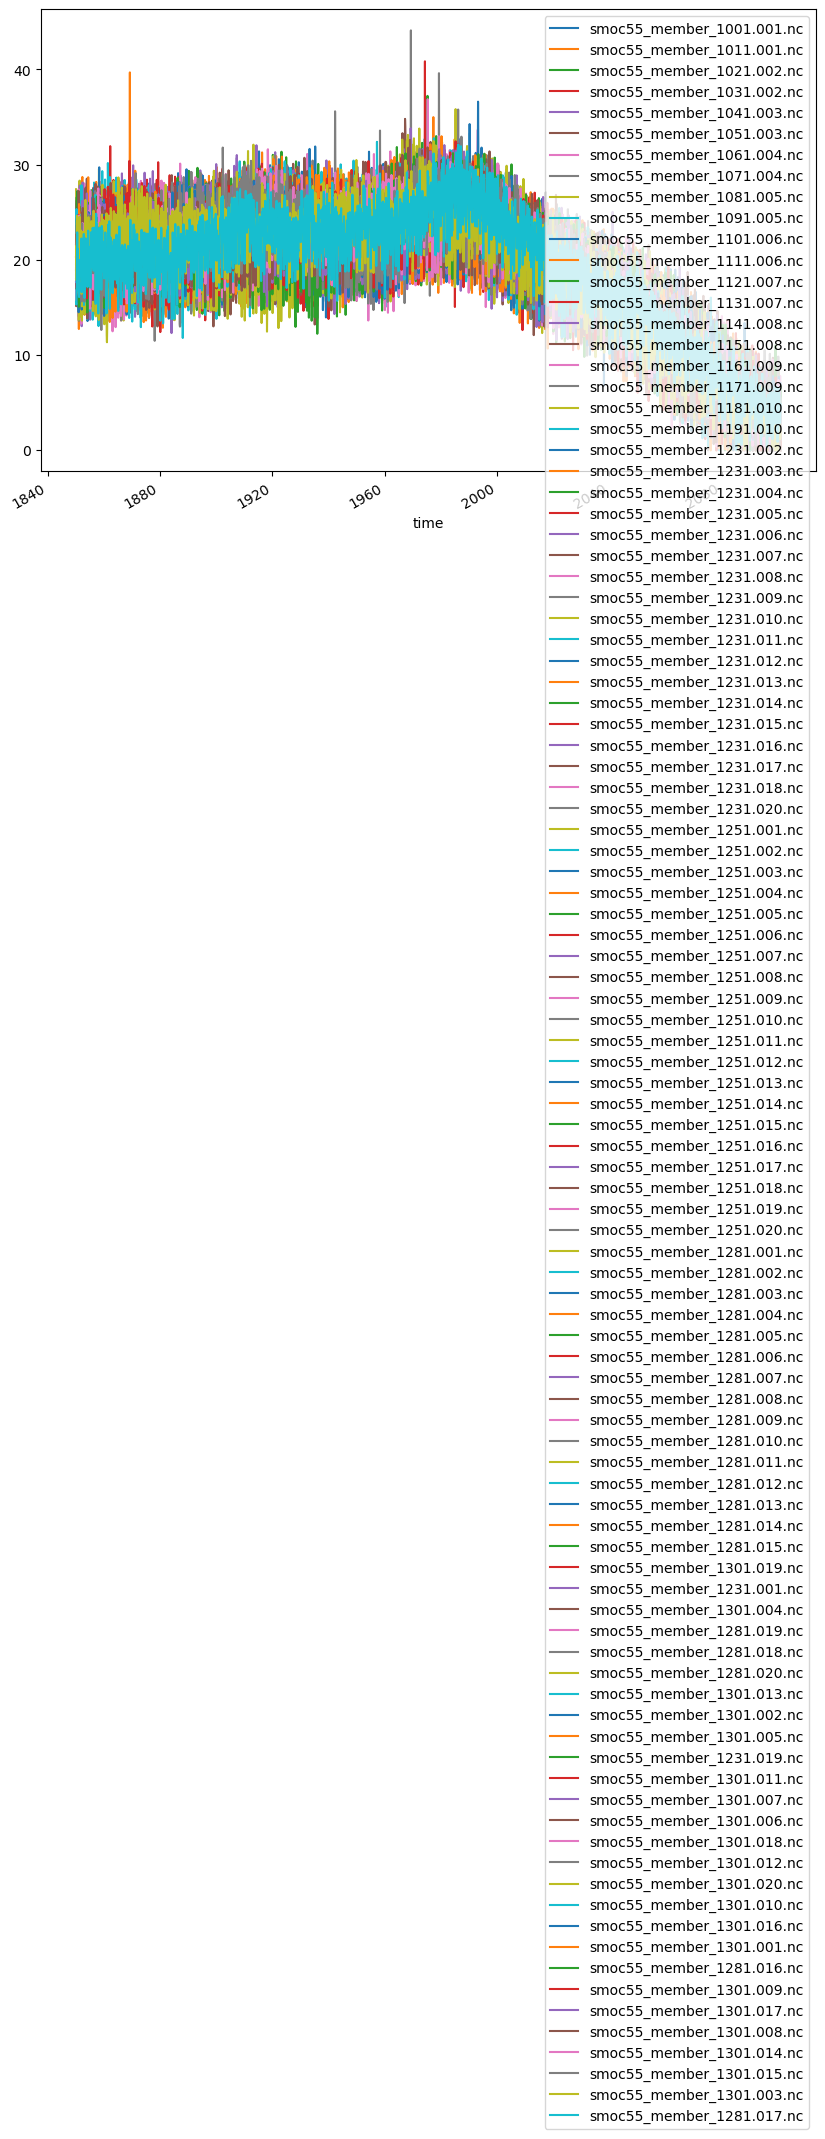

count: 100


In [90]:
# Load all NetCDF files into a list of xarray DataArrays
da_list = [xr.open_dataarray(file) for file in output]

# Plot each DataArray as its own time series
i=0
plt.figure(figsize=(10, 6))
for da in da_list:
    da.plot(label=os.path.basename(da.encoding['source']))
    i=i+1

plt.legend()
plt.show()
print('count:', i)

## Check missing files

### get number of all completed files

In [9]:
len_final_files = len('smoc55_member_1001.001.nc')

In [17]:
output_dir = '/Data/skd/scratch/innag3580/comp/smoc/'

ensemble_members = [
    "1001.001", "1011.001", "1021.002", "1031.002", "1041.003", "1051.003", "1061.004", "1071.004", "1081.005", "1091.005",
    "1101.006", "1111.006", "1121.007", "1131.007", "1141.008", "1151.008", "1161.009", "1171.009", "1181.010", "1191.010",
    "1231.001", "1231.002", "1231.003", "1231.004", "1231.005", "1231.006", "1231.007", "1231.008", "1231.009", "1231.010",
    "1231.011", "1231.012", "1231.013", "1231.014", "1231.015", "1231.016", "1231.017", "1231.018", "1231.019", "1231.020",
    "1251.001", "1251.002", "1251.003", "1251.004", "1251.005", "1251.006", "1251.007", "1251.008", "1251.009", "1251.010",
    "1251.011", "1251.012", "1251.013", "1251.014", "1251.015", "1251.016", "1251.017", "1251.018", "1251.019", "1251.020",
    "1281.001", "1281.002", "1281.003", "1281.004", "1281.005", "1281.006", "1281.007", "1281.008", "1281.009", "1281.010",
    "1281.011", "1281.012", "1281.013", "1281.014", "1281.015", "1281.016", "1281.017", "1281.018", "1281.019", "1281.020",
    "1301.001", "1301.002", "1301.003", "1301.004", "1301.005", "1301.006", "1301.007", "1301.008", "1301.009", "1301.010",
    "1301.011", "1301.012", "1301.013", "1301.014", "1301.015", "1301.016", "1301.017", "1301.018", "1301.019", "1301.020"
]

all_final_files = {f'smoc55_member_{member_id}.nc' for member_id in ensemble_members}
print('# all_final_files:', len(all_final_files))

completed_files = {f for f in os.listdir(output_dir) if len(f) == len_final_files}
print('# completed_files:', len(completed_files))

remaining_members = all_final_files - completed_files
print('# remaining members:', len(remaining_members))

# all_final_files: 100
# completed_files: 100
# remaining members: 0


### get which files still need to be computed

In [18]:
len_period_files = len('smoc55_member_1301.002_188001-188912.nc')

In [19]:
time_periods = ['185001-185912', '186001-186912', '187001-187912', '188001-188912', '189001-189912', 
                '190001-190912', '191001-191912', '192001-192912', '193001-193912', '194001-194912', 
                '195001-195912', '196001-196912', '197001-197912', '198001-198912', '199001-199912', 
                '200001-200912', '201001-201412', '201501-202412', '202501-203412', '203501-204412', 
                '204501-205412', '205501-206412', '206501-207412', '207501-208412', '208501-209412', 
                '209501-210012']

# Generate expected file names
expected_files = {f'{remaining_member[:-3]}_{time_period}.nc' 
                  for remaining_member in remaining_members 
                  for time_period in time_periods}
print('# expected_files:', len(expected_files))

completed_files = {f for f in os.listdir(output_dir) if len(f) == len_period_files}
print('# completed_files:', len(completed_files))

# Find missing files
missing_files = expected_files - completed_files
print('# missing_files:', len(missing_files))

# expected_files: 0
# completed_files: 701
# missing_files: 0


In [9]:
missing_files

{'smoc55_member_1231.019_206501-207412.nc'}

In [10]:
for file in missing_files:
    
    member_id = file[14:22]    
    time_period = file[23:36]
    
    print(member_id, time_period)

1231.019 206501-207412


### test errones files

In [11]:
err_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/err_files/*.nc'

In [12]:
err_files = glob.glob(err_dir)

In [14]:
#b.e21.BSSP370smbb.f09_g17.LE2-1231.019.pop.h.TEMP.206501-207412.nc

In [15]:
err_files

['/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/err_files/b.e21.BSSP370cmip6.f09_g17.LE2-1231.001.pop.h.SALT.204501-205412.nc',
 '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/err_files/b.e21.BSSP370smbb.f09_g17.LE2-1231.019.pop.h.TEMP.207501-208412.nc',
 '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/err_files/b.e21.BHISTsmbb.f09_g17.LE2-1281.019.pop.h.SALT.198001-198912.nc',
 '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/err_files/b.e21.BSSP370smbb.f09_g17.LE2-1301.019.pop.h.TEMP.207501-208412.nc',
 '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/err_files/b.e21.BSSP370smbb.f09_g17.LE2-1231.019.pop.h.TEMP.206501-207412.nc']

In [18]:
ds = xr.open_dataset(err_files[4])

HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140494949504832:
  #000: H5F.c line 509 in H5Fopen(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1652 in H5F_open(): unable to read superblock
    major: File accessibilty
    minor: Read failed
  #002: H5Fsuper.c line 632 in H5F__super_read(): truncated file: eof = 200982301, sblock->base_addr = 0, stored_eof = 1494307707
    major: File accessibilty
    minor: File has been truncated


OSError: [Errno -101] NetCDF: HDF error: b'/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/err_files/b.e21.BSSP370smbb.f09_g17.LE2-1231.019.pop.h.TEMP.206501-207412.nc'

In [ ]:
ds.SALT.isel(time=0,z_t=0).plot()

### compute final files

In [ ]:
# compute density bins
numbers = np.array([29.70, 31.50, 33.15, 34.75, 35.80, 36.38, 36.70, 36.89, 37.06, 37.13, 37.30])
intervals = np.diff(numbers) / 4
result = np.concatenate([np.arange(numbers[i], numbers[i+1], intervals[i]) for i in range(len(intervals))])
density_bins = np.append(result, numbers[-1])

# define paths
vvel_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL'
temp_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP'
salt_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/SALT'
base_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'
output_dir = '/Data/skd/scratch/innag3580/comp/smoc/'

In [ ]:
# select latitude
sel_nlat = 340
sel_nlon = slice(198, 254)

In [ ]:
def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def load_dataset(file):
    try:
        #ds = xr.open_dataset(file, chunks='auto') 
        ds = xr.open_dataset(file) 
        ds = ds.roll(nlon=-100)
        ds = ds.isel(nlat=sel_nlat, nlon=sel_nlon)
    except (RuntimeError, IndexError) as e:
        print(f"Loading failed for {file}: {str(e)}")
        return None
    return ds

def calculate_dens2(temp_ds, salt_ds):
    CT = gsw.conversions.CT_from_pt(salt_ds['SALT'], temp_ds['TEMP'])
    sigma2 = gsw.density.sigma2(salt_ds['SALT'], CT)
    sigma2 = sigma2.rename('SIGMA_2')
    return sigma2

def calculate_smoc55(ds_vvel, da_dens):
    
    max_overturning_series = []
    cell_thickness = ds_vvel['dz']
    cell_width = ds_vvel['DXU']
    
    for time_step in range(len(ds_vvel.time)):
        try:
            # compute meridional flow rate for the specified latitude
            velocity = ds_vvel['VVEL'].isel(time=time_step)
            flow_rate = velocity * cell_thickness * cell_width

            # compute meridional flow rate and for each density bin and integrate zonally
            density_at_time = da_dens.isel(time=time_step)
            flow_rate_by_density = np.zeros(len(density_bins))
            for bin_index in range(len(density_bins) - 1):
                in_bin = (density_at_time >= density_bins[bin_index]) & (density_at_time < density_bins[bin_index + 1])
                flow_rate_by_density[bin_index] = flow_rate.where(in_bin).sum()

            # compute density overturning, reverse to integrate from high to low density
            density_overturning = np.cumsum(flow_rate_by_density)[::-1]
            max_overturning = np.max(density_overturning)
            max_overturning_series.append(max_overturning)
            
        except IndexError as e:
            print(f"Error occurred at time step: {time_step}")
            raise e
    max_overturning_dataarray = xr.DataArray(max_overturning_series, dims=["time"], coords={"time": ds_vvel['time']})
    return max_overturning_dataarray  * 1e-12

def log_error(member_id, time_period, log_file='smoc55_error_log.txt'):
    with open(log_file, 'a') as f:
        f.write(f"{member_id} and {time_period}\n")
        
def log_memory_usage(log_file='memory_log.txt'):
    memory_info = psutil.virtual_memory()
    used_memory = memory_info.used / (1024 ** 2)  # Convert bytes to megabytes
    with open(log_file, 'a') as f:
        f.write(f"Memory Used: {used_memory:.2f} MB\n")
    return used_memory

In [ ]:
missing_files_list = list(missing_files)
file = missing_files_list[1]

member_id = file[14:22]    
time_period = file[23:36]

In [ ]:
vvel_pattern = os.path.join(vvel_dir, f'*{member_id}*{time_period}*.nc')
temp_pattern = os.path.join(temp_dir, f'*{member_id}*{time_period}*.nc')
salt_pattern = os.path.join(salt_dir, f'*{member_id}*{time_period}*.nc')

temp_files = glob.glob(temp_pattern)
salt_files = glob.glob(salt_pattern)
vvel_files = glob.glob(vvel_pattern)

In [ ]:
temp_files[0]

'/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP/b.e21.BHISTsmbb.f09_g17.LE2-1281.019.pop.h.TEMP.198001-198912.nc'

In [ ]:
ds_temp = load_dataset(temp_files[0])
#ds = xr.open_dataset(temp_files[0]) 
#ds = xr.open_dataset(temp_files[0], drop_variables='time_bound')

In [ ]:
ds_salt = load_dataset(salt_files[0])

HDF5-DIAG: Error detected in HDF5 (1.10.6) thread 140173365364544:
  #000: H5F.c line 509 in H5Fopen(): unable to open file
    major: File accessibilty
    minor: Unable to open file
  #001: H5Fint.c line 1652 in H5F_open(): unable to read superblock
    major: File accessibilty
    minor: Read failed
  #002: H5Fsuper.c line 632 in H5F__super_read(): truncated file: eof = 53329729, sblock->base_addr = 0, stored_eof = 1155967165
    major: File accessibilty
    minor: File has been truncated


OSError: [Errno -101] NetCDF: HDF error: b'/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/SALT/b.e21.BHISTsmbb.f09_g17.LE2-1281.019.pop.h.SALT.198001-198912.nc'

In [ ]:
ds_vvel = load_dataset(vvel_files[0])

In [ ]:
da_dens = calculate_dens2(ds_temp, ds_salt)
da_dens.astype('float32')

TypeError: 'NoneType' object is not subscriptable

In [ ]:
da_smoc55 = calculate_smoc55(ds_vvel, da_dens)

In [ ]:
da_smoc55.to_netcdf(os.path.join(output_dir, f'smoc55_member_{member_id}_{time_period}.nc'))

### fix files a bit more

#### check single file

In [24]:
len_period_files = len('smoc55_member_1301.002_188001-188912.nc')
completed_files = [f for f in os.listdir(output_dir) if len(f) == len_period_files]

In [25]:
completed_files[0]

'smoc55_member_1281.016_185001-185912.nc'

In [28]:
def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

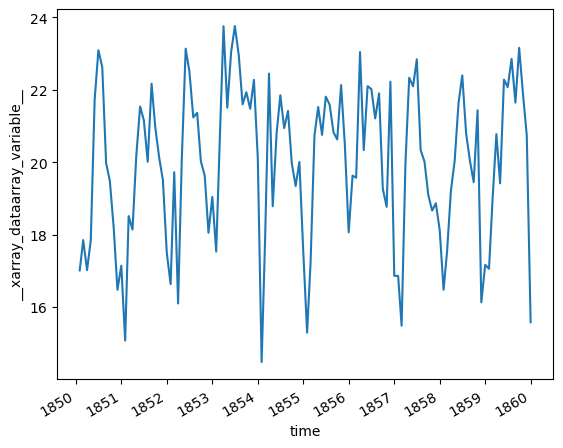

In [32]:
# load single file
ds = xr.open_dataset(output_dir+completed_files[0])

# standardise file 
ds = standardise_time(ds)

# plot file
ds.__xarray_dataarray_variable__.plot()

#### check concatenating

In [71]:
# Define the target pattern
pattern = '1301.002'

# Use a single loop to filter files
selected_files_full_path = []
for f in os.listdir(output_dir):
    if len(f) == len_period_files and pattern in f and f.endswith('.nc'):
        selected_files_full_path.append(os.path.join(output_dir, f))
        
selected_files_full_path.sort()

In [72]:
# Initialize an empty list to hold datasets
datasets = []

# Load datasets and standardize time
for file_path in selected_files_full_path:
    ds = xr.open_dataset(file_path)
    ds = standardise_time(ds)  # Standardizing the dataset
    datasets.append(ds)

# Concatenate datasets along the time dimension
concatenated_ds = xr.concat(datasets, dim='time')

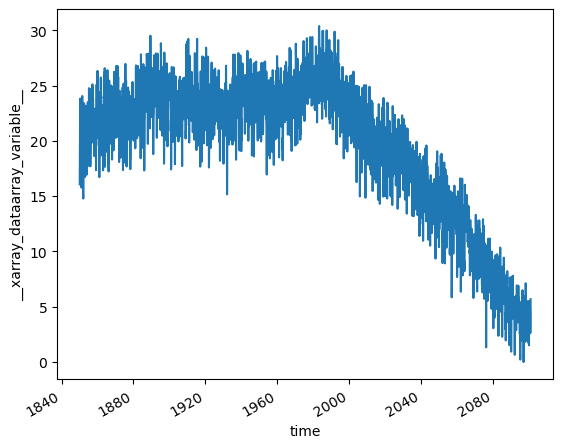

In [73]:
concatenated_ds.__xarray_dataarray_variable__.plot()

### write concatenating for all weird members

In [ ]:
# find all weird members

In [62]:
# Use a set to store unique variations
unique_variations = set()

# Define a regular expression pattern to match the desired format
pattern = re.compile(r'smoc55_member_(\d{4}\.\d{3})_\d{6}-\d{6}\.nc')

# Loop through files in the directory
for filename in os.listdir(output_dir):
    match = pattern.match(filename)
    if match:
        # Add the variation to the set
        unique_variations.add(match.group(1))

# Print the unique variations
unique_variations

{'1231.001',
 '1231.019',
 '1281.016',
 '1281.017',
 '1281.018',
 '1281.019',
 '1281.020',
 '1301.001',
 '1301.002',
 '1301.003',
 '1301.004',
 '1301.005',
 '1301.006',
 '1301.007',
 '1301.008',
 '1301.009',
 '1301.010',
 '1301.011',
 '1301.012',
 '1301.013',
 '1301.014',
 '1301.015',
 '1301.016',
 '1301.017',
 '1301.018',
 '1301.019',
 '1301.020'}

In [69]:
for member_id in unique_variations:
    
    pattern = f'*{member_id}_*.nc'
    file_list = glob.glob(output_dir + pattern)
    file_list.sort()
    break

### delete files

In [86]:
for member_id in unique_variations:
    
    pattern = f'*{member_id}.nc'
    file = glob.glob(output_dir + pattern)
    
    if file:
    
        os.remove(file[0])
    
        print(file[0], ' removed')

/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.005.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.003.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.004.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.011.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.001.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.012.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.019.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1281.016.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.017.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.006.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.016.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.014.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1231.001.nc  removed
/Data/skd/scratch/innag3580/comp/smoc/smoc55_member

## store working code that deals with weird files

In [ ]:
### INTERVENTION ###
len_final_files = len('smoc55_member_1001.001.nc')
len_period_files = len('smoc55_member_1301.002_188001-188912.nc')

all_final_files = {f'smoc55_member_{member_id}.nc' for member_id in ensemble_members}
print('# all_final_files:', len(all_final_files))

completed_files = {f for f in os.listdir(output_dir) if len(f) == len_final_files}
print('# completed_files:', len(completed_files))

remaining_members = all_final_files - completed_files
print('# remaining members:', len(remaining_members))

expected_files = {f'{remaining_member[:-3]}_{time_period}.nc' 
                  for remaining_member in remaining_members 
                  for time_period in time_periods}
print('# expected_files:', len(expected_files))

completed_files = {f for f in os.listdir(output_dir) if len(f) == len_period_files}
print('# completed_files:', len(completed_files))

# Find missing files
missing_files = expected_files - completed_files
print('# missing_files:', len(missing_files))

for file in missing_files:
    
    member_id = file[14:22]    
    time_period = file[23:36]
    
    task = dask.delayed(process_files)(member_id, time_period)
    tasks.append(task)
    
### INTERVENTION ###    

In [ ]:
#for member_id in ensemble_members:
for save_name in remaining_members:
    member_id = save_name[14:22]
    
    
    pattern = f'*{member_id}*.nc'
    file_list = glob.glob(output_dir + pattern)
    file_list.sort()

    ds_concat = xr.concat([xr.open_dataset(f) for f in file_list], dim='new_dimension_name')
    ds_concat.to_netcdf(os.path.join(output_dir, f'smoc55_member_{member_id}.nc'))

    print(member_id, ' saved')

# Fix file problem

In [ ]:
def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

In [5]:
path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'
temp_file = 'temp/temp_'+'1281.017.nc' # starts to be weird with '1281.017.nc'
salt_file = 'salt/salt_'+'1281.017.nc' # starts to be weird with '1281.017.nc'
vvel_file = 'vvel/vvel_'+'1281.016.nc' # starts to be weird with '1281.016.nc'

In [8]:
# ID to filter by
i = '1281.018'

# List all files matching the pattern
file_pattern = os.path.join(path, 'TEMP', f'*LE2-{i}*')
#file_paths = sorted(glob.glob(file_pattern))
file_paths = glob.glob(file_pattern)

## check files concatenated with `combine.sh`

In [ ]:
ds_test = xr.open_dataset(path+temp_file)

In [ ]:
ds_test = standardise_time(ds_test)

In [ ]:
ds_test.TEMP.isel(nlat=340, nlon=0, z_t=0).plot()

## does opening the original files already not work?

0


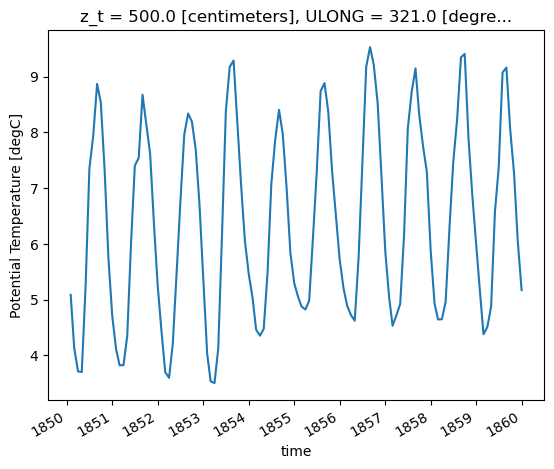

1


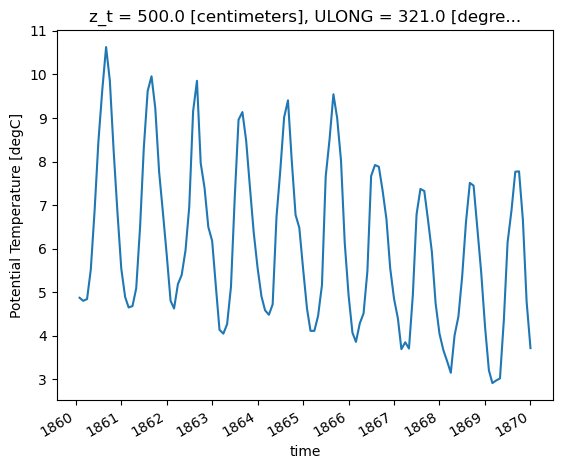

2


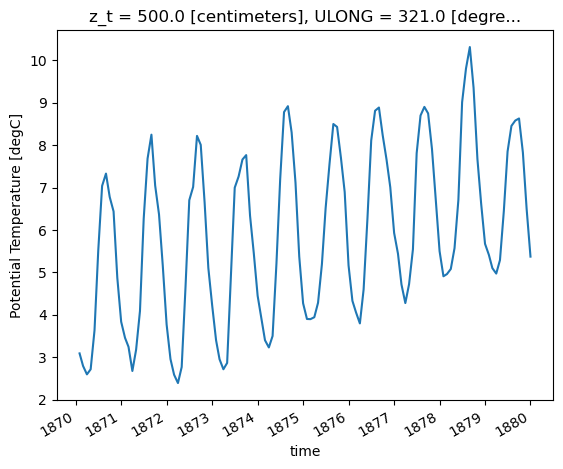

3


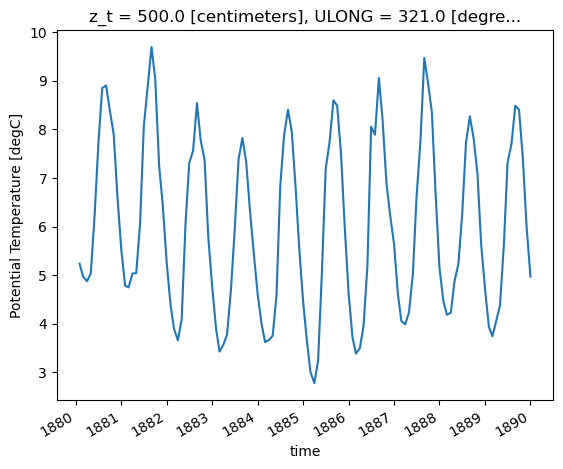

4


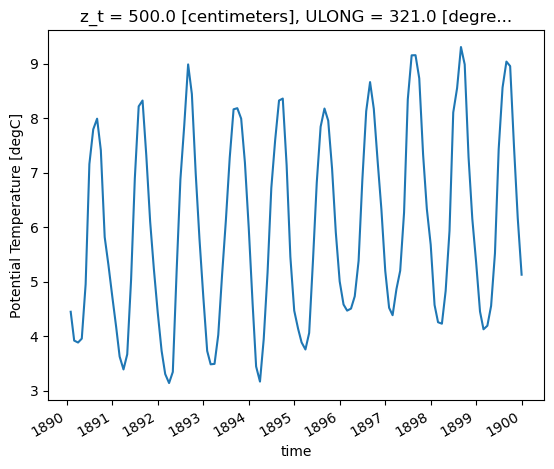

5


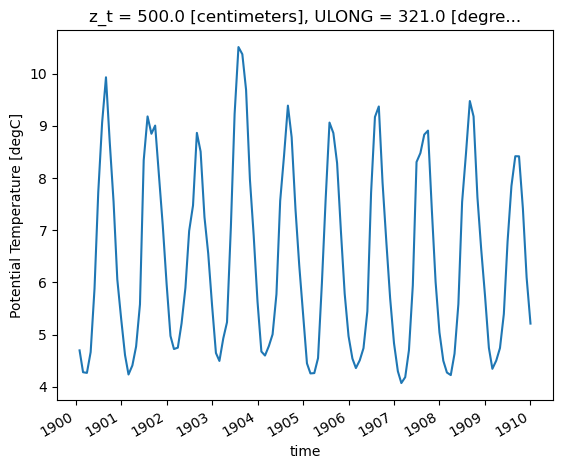

6


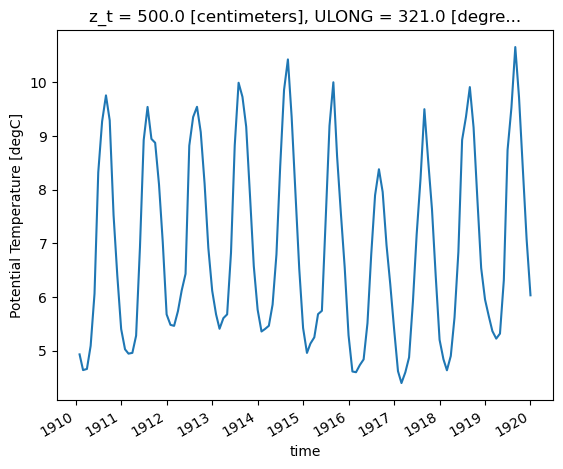

7


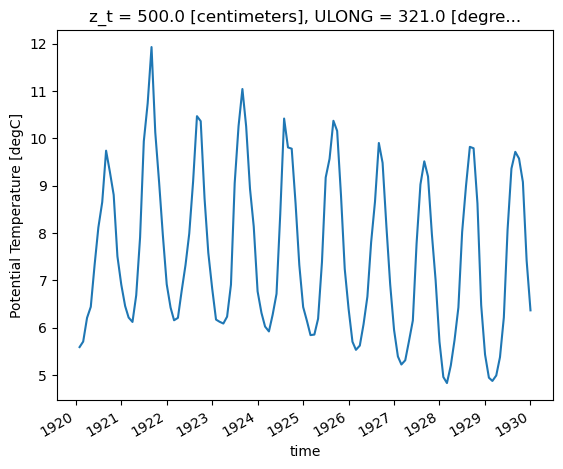

8


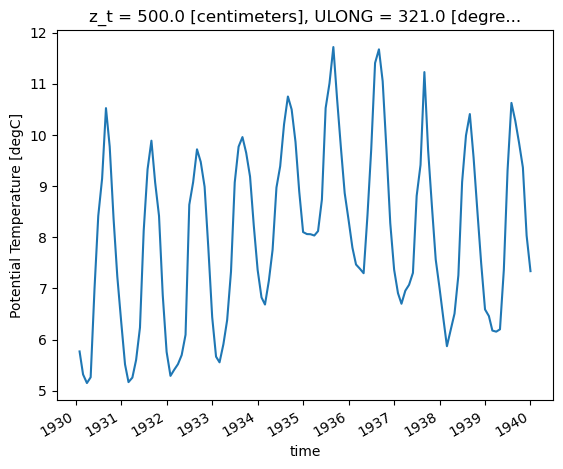

9


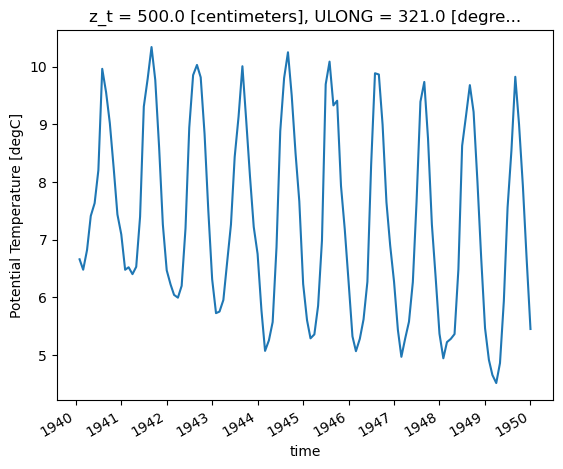

10


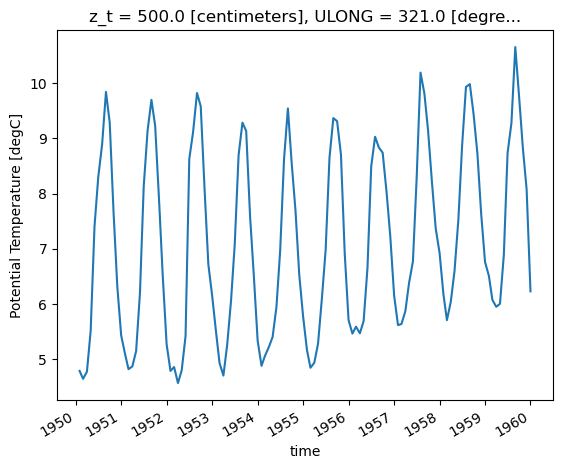

11


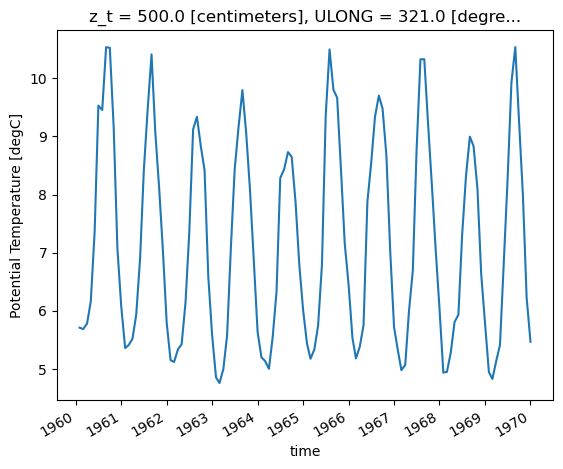

12


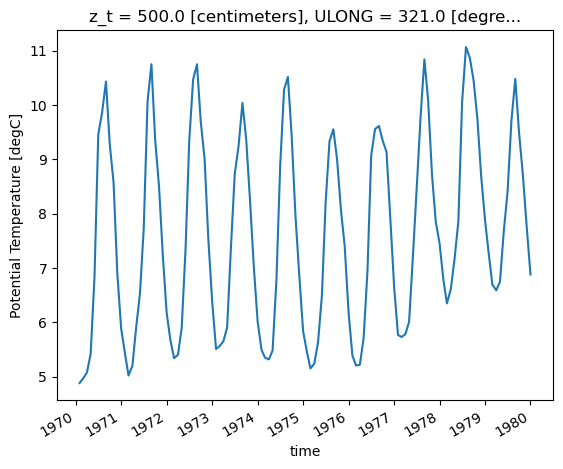

13


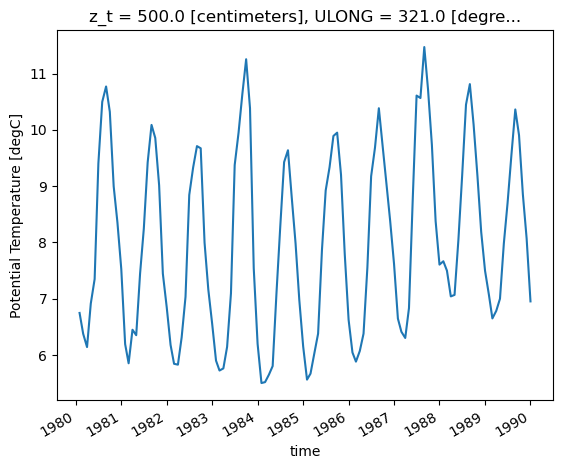

14


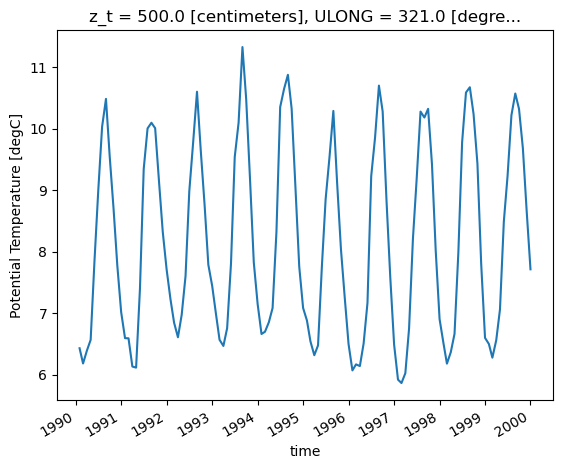

15


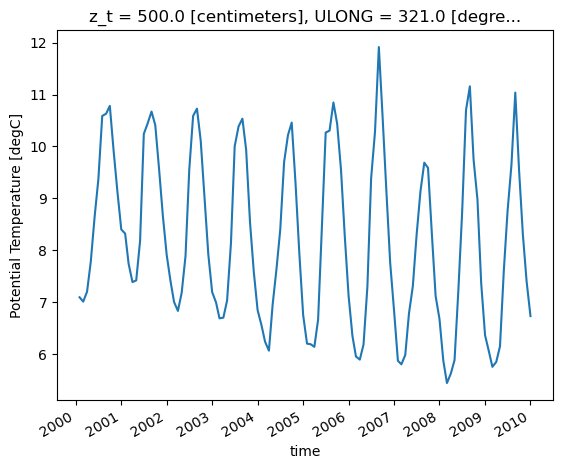

16


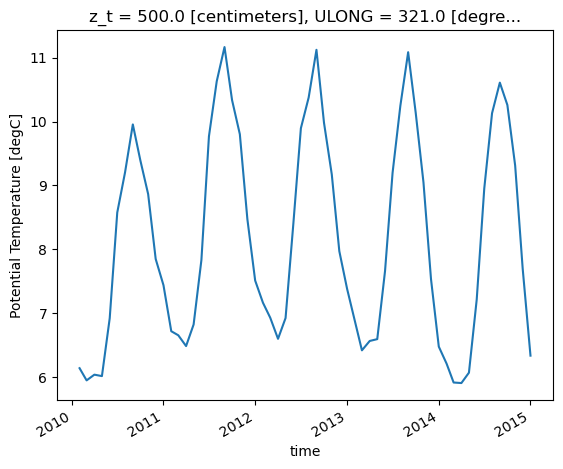

17


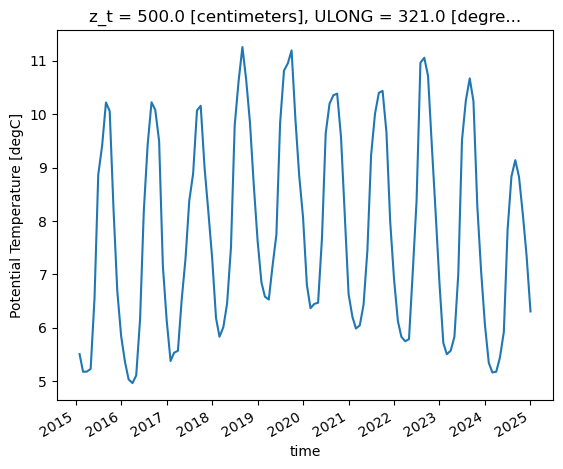

18


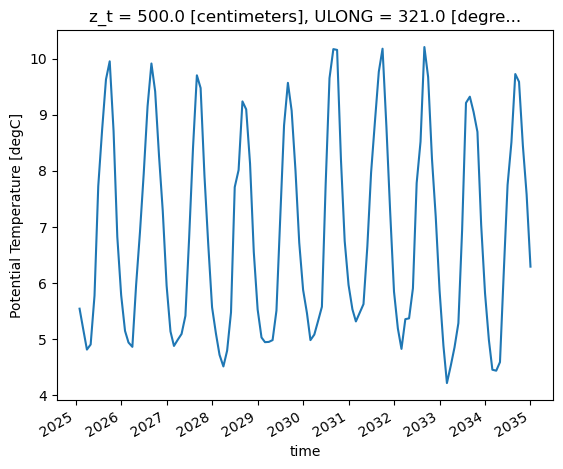

19


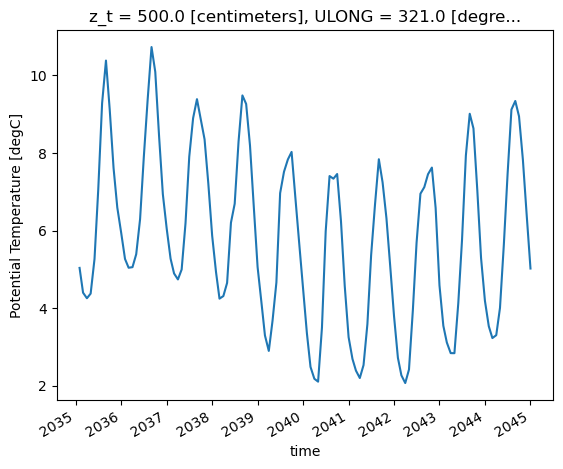

20


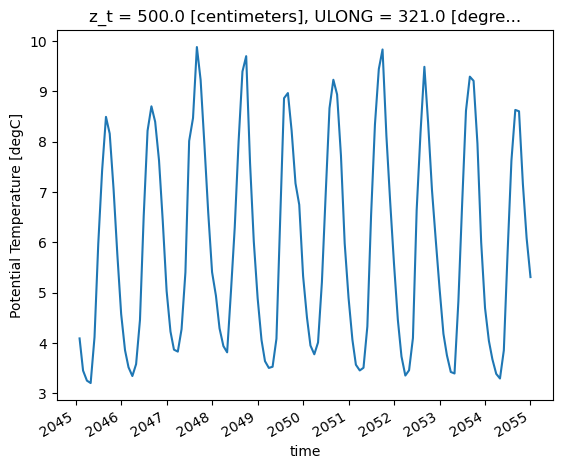

21


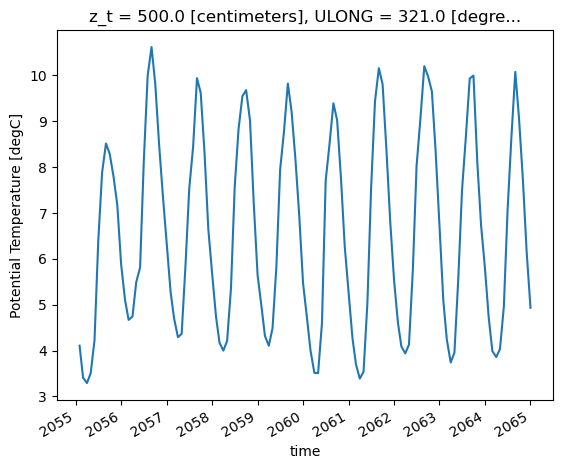

22


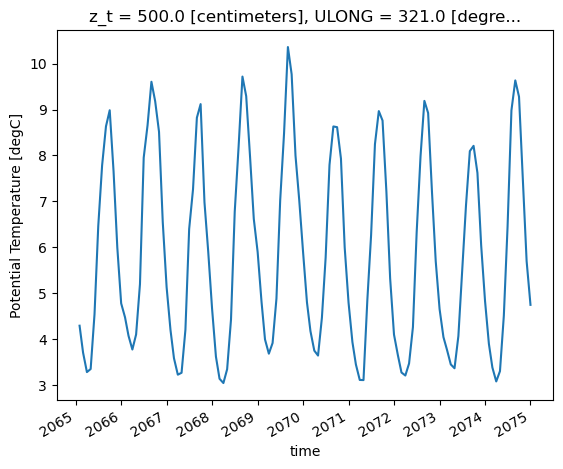

23


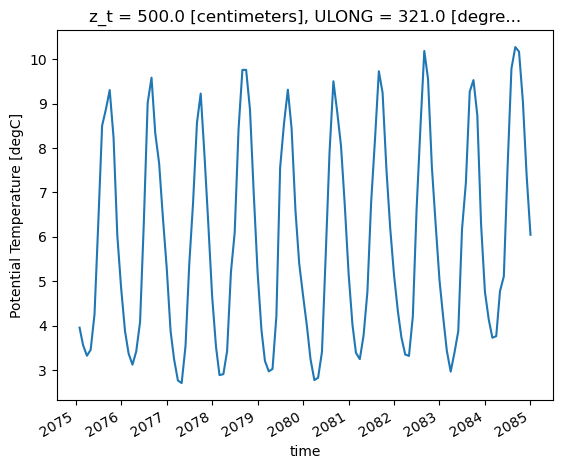

24


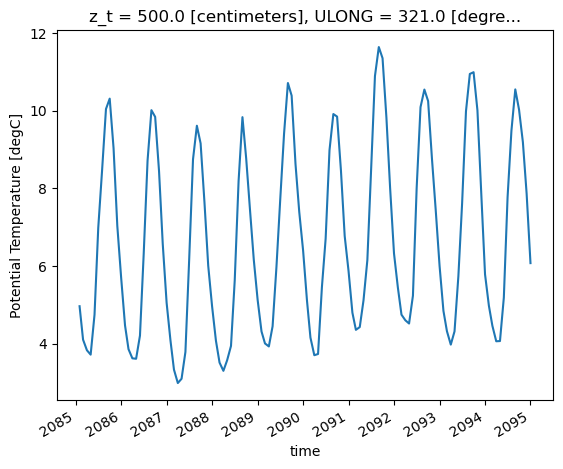

25


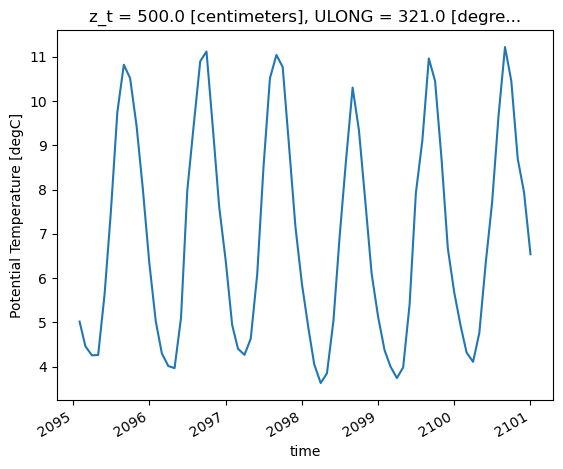

In [38]:
for i in range(len(file_paths)):
    print(i)
    ds = xr.open_dataset(file_paths[i])
    ds = standardise_time(ds)
    ds.TEMP.isel(z_t=0, nlat=340, nlon=0).plot()
    plt.show()

## check if concatenating with python works

In [9]:
# Open datasets
#datasets = [xr.open_dataset(file, decode_times=False) for file in file_paths]
datasets = [xr.open_dataset(file) for file in file_paths]

# Concatenate datasets along the time dimension
ds = xr.concat(datasets, dim='time')

In [10]:
ds = standardise_time(ds)

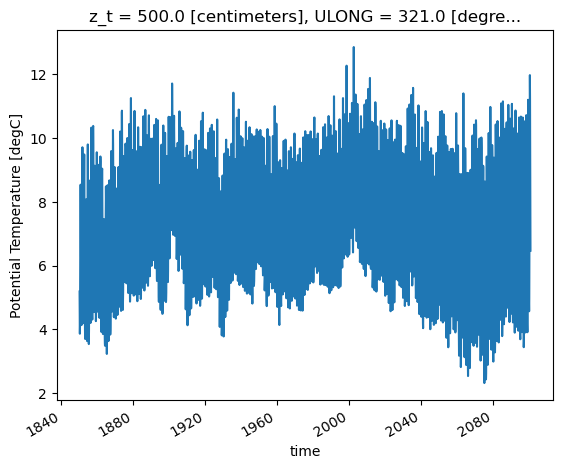

In [11]:
ds.TEMP.isel(nlat=340, nlon=0, z_t=0).plot()

# Combine files

In [32]:
output_dir = '/Data/skd/scratch/innag3580/comp/smoc/'

len_final_files = len('smoc55_member_1001.001.nc')

In [22]:
output_dir = '/Data/skd/scratch/innag3580/comp/smoc/'

ensemble_members = [
    "1001.001", "1011.001", "1021.002", "1031.002", "1041.003", "1051.003", "1061.004", "1071.004", "1081.005", "1091.005",
    "1101.006", "1111.006", "1121.007", "1131.007", "1141.008", "1151.008", "1161.009", "1171.009", "1181.010", "1191.010",
    "1231.001", "1231.002", "1231.003", "1231.004", "1231.005", "1231.006", "1231.007", "1231.008", "1231.009", "1231.010",
    "1231.011", "1231.012", "1231.013", "1231.014", "1231.015", "1231.016", "1231.017", "1231.018", "1231.019", "1231.020",
    "1251.001", "1251.002", "1251.003", "1251.004", "1251.005", "1251.006", "1251.007", "1251.008", "1251.009", "1251.010",
    "1251.011", "1251.012", "1251.013", "1251.014", "1251.015", "1251.016", "1251.017", "1251.018", "1251.019", "1251.020",
    "1281.001", "1281.002", "1281.003", "1281.004", "1281.005", "1281.006", "1281.007", "1281.008", "1281.009", "1281.010",
    "1281.011", "1281.012", "1281.013", "1281.014", "1281.015", "1281.016", "1281.017", "1281.018", "1281.019", "1281.020",
    "1301.001", "1301.002", "1301.003", "1301.004", "1301.005", "1301.006", "1301.007", "1301.008", "1301.009", "1301.010",
    "1301.011", "1301.012", "1301.013", "1301.014", "1301.015", "1301.016", "1301.017", "1301.018", "1301.019", "1301.020"
]

all_final_files = {f'smoc55_member_{member_id}.nc' for member_id in ensemble_members}
print('# all_final_files:', len(all_final_files))

completed_files = {f for f in os.listdir(output_dir) if len(f) == len_final_files}
print('# completed_files:', len(completed_files))

remaining_members = all_final_files - completed_files
print('# remaining members:', len(remaining_members))

# all_final_files: 100
# completed_files: 73
# remaining members: 27


In [38]:
remaining_members

{'smoc55_member_1231.001.nc',
 'smoc55_member_1231.019.nc',
 'smoc55_member_1281.016.nc',
 'smoc55_member_1281.017.nc',
 'smoc55_member_1281.018.nc',
 'smoc55_member_1281.019.nc',
 'smoc55_member_1281.020.nc',
 'smoc55_member_1301.001.nc',
 'smoc55_member_1301.002.nc',
 'smoc55_member_1301.003.nc',
 'smoc55_member_1301.004.nc',
 'smoc55_member_1301.005.nc',
 'smoc55_member_1301.006.nc',
 'smoc55_member_1301.007.nc',
 'smoc55_member_1301.008.nc',
 'smoc55_member_1301.009.nc',
 'smoc55_member_1301.010.nc',
 'smoc55_member_1301.011.nc',
 'smoc55_member_1301.012.nc',
 'smoc55_member_1301.013.nc',
 'smoc55_member_1301.014.nc',
 'smoc55_member_1301.015.nc',
 'smoc55_member_1301.016.nc',
 'smoc55_member_1301.017.nc',
 'smoc55_member_1301.018.nc',
 'smoc55_member_1301.019.nc',
 'smoc55_member_1301.020.nc'}

In [44]:
# find relevant members
for save_name in remaining_members:
    
    
    

    member_id = save_name[14:22]
    print(member_id, ' started')
    
    pattern = f'*{member_id}*.nc'

    # find all files of member
    file_list = glob.glob(output_dir + pattern)

    # sort members
    file_list.sort()
    
   

    # open datasets 
    #datasets = [xr.open_dataset(file) for file in file_paths]

    # concatenate members
    #ds = xr.concat(datasets, dim='time')
    ds_concat = xr.concat([xr.open_dataset(f) for f in file_list], dim='new_dimension_name')



    # save members
    #da_smoc55.to_netcdf(os.path.join(output_dir, f'smoc55_member_{member_id}.nc'))
    
    break

1301.018  started
['/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_185001-185912.nc', '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_186001-186912.nc', '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_187001-187912.nc', '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_188001-188912.nc', '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_189001-189912.nc', '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_190001-190912.nc', '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_191001-191912.nc', '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_192001-192912.nc', '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_193001-193912.nc', '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_194001-194912.nc', '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_195001-195912.nc', '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1301.018_196001-196912.nc', '/Data/sk

In [45]:
ds_concat

<xarray.Dataset>
Dimensions:                        (time: 3012, new_dimension_name: 26)
Coordinates:
  * time                           (time) object 1850-02-01 00:00:00 ... 2101...
Dimensions without coordinates: new_dimension_name
Data variables:
    __xarray_dataarray_variable__  (new_dimension_name, time) float64 15.83 ....

In [ ]:
# Use glob to find all files matching the pattern
file_list = glob.glob(directory + pattern)

# Sort the files
file_list.sort()

# Open and concatenate the datasets
ds_concat = xr.concat([xr.open_dataset(f) for f in file_list], dim='new_dimension_name')

# Save the concatenated dataset to a new NetCDF file
ds_concat.to_netcdf('output.nc')

In [ ]:
for member_id in ensemble_members:
    
    print(member_id, ' started')
    
    file_paths = {}
    
    try:
        # Loop through each variable
        for variable in variables:
            # Construct the pattern and find matching files
            file_pattern = os.path.join(base_path, variable, f'*LE2-{member_id}*.nc')
            matching_files = sorted(glob.glob(file_pattern))

In [ ]:
for member, group_data in grouped:
    member_id = f"{float(member):.3f}"

    #file = var_location + var + member + '.nc'
    file_pattern = os.path.join(base_path, variable, f'*BHIST*LE2-{member_id}*.nc')
    file_paths = sorted(glob.glob(file_pattern))

    datasets = []
    for file in file_paths:
        ds_member = xr.open_dataset(file, chunks={'time': 12})

In [ ]:
datasets = [xr.open_dataset(file, chunks={'time': 10, 'nlat': 60, 'nlon': 60}) for file in file_paths]

    # Concatenate datasets along the time dimension
    ds = xr.concat(datasets, dim='time')

# working slow code

In [61]:
#!/usr/bin/env python3
# inagler 21/11/24

import time

import os
import gc
import glob

import numpy as np
import pandas as pd
import xarray as xr
import dask.array as da

import cftime
import pop_tools  
import gsw

start_time = time.time()

# compute desnity bins
numbers = np.array([29.70, 31.50, 33.15, 34.75, 35.80, 36.38, 36.70, 36.89, 37.06, 37.13, 37.30])
intervals = np.diff(numbers) / 4
result = np.concatenate([np.arange(numbers[i], numbers[i+1], intervals[i]) for i in range(len(intervals))])
density_bins = np.append(result, numbers[-1])

# define paths
#vvel_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/VVEL'
#temp_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/TEMP'
#salt_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/SALT'
base_path = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/'
output_dir = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp_2/smoc/'

# define ensemble members
ensemble_members = [
    #"1001.001", "1011.001", "1021.002", "1031.002", "1041.003", "1051.003", "1061.004", "1071.004", "1081.005", "1091.005",
    #"1101.006", "1111.006", "1121.007", "1131.007", "1141.008", "1151.008", "1161.009", "1171.009", "1181.010", "1191.010",
    #"1231.001", "1231.002", "1231.003", "1231.004", "1231.005", "1231.006", "1231.007", "1231.008", "1231.009", "1231.010",
    #"1231.011", "1231.012", "1231.013", "1231.014", "1231.015", "1231.016", "1231.017", "1231.018", "1231.019", "1231.020",
    #"1251.001", "1251.002", "1251.003", "1251.004", "1251.005", "1251.006", "1251.007", "1251.008", "1251.009", "1251.010",
    #"1251.011", "1251.012", "1251.013", "1251.014", "1251.015", "1251.016", "1251.017", "1251.018", "1251.019", "1251.020",
    #"1281.001", "1281.002", "1281.003", "1281.004", "1281.005", "1281.006", "1281.007", "1281.008", "1281.009", "1281.010",
    #"1281.011", "1281.012", "1281.013", "1281.014", "1281.015", 
    "1281.016", "1281.017", "1281.018", "1281.019", "1281.020",
    "1301.001", "1301.002", "1301.003", "1301.004", "1301.005", "1301.006", "1301.007", "1301.008", "1301.009", "1301.010",
    "1301.011", "1301.012", "1301.013", "1301.014", "1301.015", "1301.016", "1301.017", "1301.018", "1301.019", "1301.020"
]

# define the variables
variables = ['TEMP', 'SALT', 'VVEL']

# select latitude
sel_nlat = 340

# set up mask
# this is not the most elegant way, it would be better to just give the nlon range
grid_name = 'POP_gx1v7'
region_defs = {
    'subzero_Atlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [53.0, 58.0], 'TLONG': [260.0, 357.0]}}
    ],
    #'superzero_Atlantic':[
    #    {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [53.0, 58.0], 'TLONG': [0, 5.0]}}
    #],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [53.0, 58.0]}}
    ]
}
moc55_mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='Overturning at 55N Mask')
moc55_mask = moc55_mask.sum('region')
moc55_mask = moc55_mask.roll(nlon=-100)

def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def load_and_process_dataset(file_paths, mask):
    # Open datasets with Dask and apply chunking
    datasets = [xr.open_dataset(file, chunks={'time': 10, 'nlat': 60, 'nlon': 60}) for file in file_paths]

    # Concatenate datasets along the time dimension
    ds = xr.concat(datasets, dim='time')
    ds = standardise_time(ds)
    
    try:
        processed_dataset = ds.roll(nlon=-100).where(mask)
    except (RuntimeError, IndexError) as e:
        print(f"Initial processing failed, loading step-by-step: {str(e)}")
        processed_dataset = handle_deprecated_data(ds, mask)
    return processed_dataset

def handle_deprecated_data(ds, mask):
    total_time_steps = ds.dims['time']
    last_valid_data = None
    for t in range(total_time_steps):
        try:
            current_data = ds.isel(time=t).load()
            last_valid_data = current_data
        except RuntimeError as e:
            print(f"Error at timestep {t}: {str(e)}")
            if last_valid_data is not None:
                current_data = last_valid_data
            else:
                raise ValueError(f"No valid data at timestep {t}")
        if t == 0:
            combined_data = current_data
        else:
            combined_data = xr.concat([combined_data, current_data], dim='time')
    combined_data['time'] = np.arange(total_time_steps)
    result_dataset = combined_data.roll(nlon=-100).where(mask)
    return result_dataset

def calculate_dens2(temp_ds, salt_ds, nlat):
    CT = gsw.conversions.CT_from_pt(salt_ds['SALT'].isel(nlat=nlat), temp_ds['TEMP'].isel(nlat=nlat))
    sigma2_at_latitude = gsw.density.sigma2(salt_ds['SALT'].isel(nlat=nlat), CT)
    sigma2_at_latitude = sigma2_at_latitude.rename('SIGMA_2')
    return sigma2_at_latitude

def calculate_smoc55(ds_vvel, da_dens, latitude_index):
    
    #meridional_density = da_dens.mean(dim=['nlon'])
    
    max_overturning_series = []

    cell_thickness = ds_vvel['dz'].isel(nlat=latitude_index)
    cell_width = ds_vvel['DXU'].isel(nlat=latitude_index)
    
    for time_step in range(len(ds_vvel.time)):
       
        #if time_step % (12 * 10) == 0:
        print(f'time step: {time_step}/{len(ds_vvel.time)}')
        
        try:
            # compute meridional flow rate for the specified latitude
            velocity = ds_vvel['VVEL'].isel(time=time_step, nlat=latitude_index)
            flow_rate = velocity * cell_thickness * cell_width
            
            if time_step % (12 * 10) == 0:
                print(f'flow rate computed')
            
            # compute density bins
            #density_at_time = meridional_density.isel(time=time_step)
            #densities = density_at_time.values
            #sorted_indices = np.argsort(densities)
            #density_bins = densities[sorted_indices]

            # compute meridional flow rate and for each density bin and integrate zonally
            density_at_time = da_dens.isel(time=time_step)
            flow_rate_by_density = np.zeros(len(density_bins))
            for bin_index in range(len(density_bins) - 1):
                in_bin = (density_at_time >= density_bins[bin_index]) & (density_at_time < density_bins[bin_index + 1])
                flow_rate_by_density[bin_index] = flow_rate.where(in_bin).sum()
            if time_step % (12 * 10) == 0:
                print(f'in density space computed')

            # compute density overturning, reverse to integrate from high to low density
            density_overturning = np.cumsum(flow_rate_by_density)[::-1]
            max_overturning = np.max(density_overturning)
            max_overturning_series.append(max_overturning)
            
            if time_step % (12 * 10) == 0:
                print(f'overturning computed')
            
        except IndexError as e:
            print(f"Error occurred at time step: {time_step}")
            raise e
    
    max_overturning_dataarray = xr.DataArray(max_overturning_series, dims=["time"], coords={"time": ds_vvel['time']})
    #return density_bins, max_overturning_dataarray  * 1e-12
    return max_overturning_dataarray  * 1e-12

def log_error_member(member_id, log_file='smoc55_error_log.txt'):
    with open(log_file, 'a') as f:
        f.write(f"{member_id}\n")

for member_id in ensemble_members:
    
    print(member_id, ' started')
    
    file_paths = {}
    
    try:
        # Loop through each variable
        for variable in variables:
            # Construct the pattern and find matching files
            file_pattern = os.path.join(base_path, variable, f'*LE2-{member_id}*.nc')
            matching_files = sorted(glob.glob(file_pattern))

            # Store the matching files in the dictionary
            file_paths[variable] = matching_files

        # Process the datasets for TEMP, SALT, and VVEL
        ds_temp = load_and_process_dataset(file_paths['TEMP'], moc55_mask)
        print('ds_temp loaded')
        ds_salt = load_and_process_dataset(file_paths['SALT'], moc55_mask)
        print('ds_salt loaded')
        ds_vvel = load_and_process_dataset(file_paths['VVEL'], moc55_mask)
        print('ds_vvel loaded')

        da_dens = calculate_dens2(ds_temp, ds_salt, sel_nlat)
        print('da_dens computed')
        
        ds_temp.close()
        ds_salt.close()
        
        #density_bins, da_smoc55 = calculate_smoc55(ds_vvel, da_dens, sel_nlat)
        da_smoc55 = calculate_smoc55(ds_vvel, da_dens, sel_nlat)
        print('smoc55 computed')
        
        ds_vvel.close()
        da_dens.close()
        
        da_smoc55.to_netcdf(os.path.join(output_dir, f'smoc55_member_{member_id}.nc'))
        print(f'{member_id} saved')

        da_smoc55.close()

        del ds_temp, ds_salt, ds_vvel, da_dens, da_smoc55
        
        gc.collect()
        
    except IndexError as e:
        print(f"Error occurred for member: {member_id}")
        log_error_member(member_id)
        continue

print('')
print('computation complete')
print('')
end_time = time.time()
duration = end_time - start_time
print(f"Execution time: {duration} seconds")

Starting processing for member: 1301.010, time period: 198001-198912Starting processing for member: 1281.016, time period: 188001-188912

Starting processing for member: 1301.009, time period: 188001-188912
Starting processing for member: 1301.009, time period: 194001-194912
Starting processing for member: 1301.003, time period: 209501-210012
Starting processing for member: 1301.008, time period: 194001-194912
Starting processing for member: 1301.011, time period: 209501-210012
Starting processing for member: 1301.020, time period: 186001-186912
Starting processing for member: 1301.008, time period: 205501-206412
Starting processing for member: 1301.019, time period: 190001-190912
Starting processing for member: 1301.015, time period: 203501-204412
Starting processing for member: 1301.015, time period: 201001-201412
Starting processing for member: 1301.003, time period: 194001-194912
Starting processing for member: 1301.018, time period: 190001-190912
Starting processing for member: 12

KeyboardInterrupt: 

# Delete files

In [7]:
output_dir = '/Data/skd/scratch/innag3580/comp/smoc/'

ensemble_members = [
    "1001.001", "1011.001", "1021.002", "1031.002", "1041.003", "1051.003", "1061.004", "1071.004", "1081.005", "1091.005",
    "1101.006", "1111.006", "1121.007", "1131.007", "1141.008", "1151.008", "1161.009", "1171.009", "1181.010", "1191.010",
    "1231.001", "1231.002", "1231.003", "1231.004", "1231.005", "1231.006", "1231.007", "1231.008", "1231.009", "1231.010",
    "1231.011", "1231.012", "1231.013", "1231.014", "1231.015", "1231.016", "1231.017", "1231.018", "1231.019", "1231.020",
    "1251.001", "1251.002", "1251.003", "1251.004", "1251.005", "1251.006", "1251.007", "1251.008", "1251.009", "1251.010",
    "1251.011", "1251.012", "1251.013", "1251.014", "1251.015", "1251.016", "1251.017", "1251.018", "1251.019", "1251.020",
    "1281.001", "1281.002", "1281.003", "1281.004", "1281.005", "1281.006", "1281.007", "1281.008", "1281.009", "1281.010",
    "1281.011", "1281.012", "1281.013", "1281.014", "1281.015", "1281.016", "1281.017", "1281.018", "1281.019", "1281.020",
    "1301.001", "1301.002", "1301.003", "1301.004", "1301.005", "1301.006", "1301.007", "1301.008", "1301.009", "1301.010",
    "1301.011", "1301.012", "1301.013", "1301.014", "1301.015", "1301.016", "1301.017", "1301.018", "1301.019", "1301.020"
]

In [11]:
for member_id in ensemble_members:
    
    pattern = f'*{member_id}_*.nc'
    file_list = glob.glob(output_dir + pattern)
    
    if file_list:
        for file_path in file_list:
                os.remove(file_path)

In [9]:
file_list

[]

# Compute ensemble mean

In [35]:
files = 'smoc55_member_*.nc'
files = glob.glob(output_dir+files)        

In [36]:
files

['/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1001.001.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1011.001.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1021.002.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1031.002.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1041.003.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1051.003.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1061.004.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1071.004.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1081.005.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1091.005.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1101.006.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1111.006.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1121.007.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_member_1131.007.nc',
 '/Data/skd/scratch/innag3580/comp/smoc/smoc55_m

In [37]:
ensemble_mean = xr.open_mfdataset(files, concat_dim='new_dim', combine='nested').mean(dim='new_dim')

In [38]:
ensemble_mean.__xarray_dataarray_variable__.to_netcdf(os.path.join(output_dir, 'smoc55_ensemble_mean.nc'))

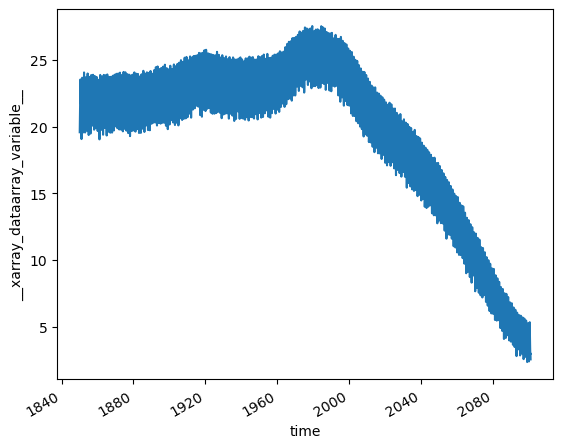

In [39]:
ensemble_mean.__xarray_dataarray_variable__.plot()

In [40]:
xr.load_dataarray(os.path.join(output_dir, 'smoc55_ensemble_mean.nc'))

<xarray.DataArray (time: 3012)>
array([19.5707761 , 20.34616184, 21.23104793, ...,  2.94587466,
        3.02126616,  2.56963369])
Coordinates:
  * time     (time) datetime64[ns] 1850-02-01 1850-03-01 ... 2101-01-01

# CODE FOR ALL LATITUDES

In [7]:
ds = xr.load_dataset(vvel_dir+vvel_file)

NameError: name 'vvel_dir' is not defined

In [5]:
# this is not the most elegant way, it would be better to just give the nlon range
grid_name = 'POP_gx1v7'
region_defs = {
    'subzero_Atlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [-30.0, 66.0], 'TLONG': [260.0, 360.0]}}
    ],
    'superzero_Atlantic':[
        {'match': {'REGION_MASK': [6]}, 'bounds': {'TLAT': [-30.0, 66.0], 'TLONG': [0, 20.0]}}
    ],
    'Mediterranean': [
        {'match': {'REGION_MASK': [7]}}
    ],
    'LabradorSea': [
        {'match': {'REGION_MASK': [8]}, 'bounds': {'TLAT': [45.0, 66.0]}}
    ]
}
moc_mask = pop_tools.region_mask_3d(grid_name, region_defs=region_defs, mask_name='Meridional Overturning Mask')
moc_mask = moc_mask.sum('region')
moc_mask = moc_mask.roll(nlon=-100)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


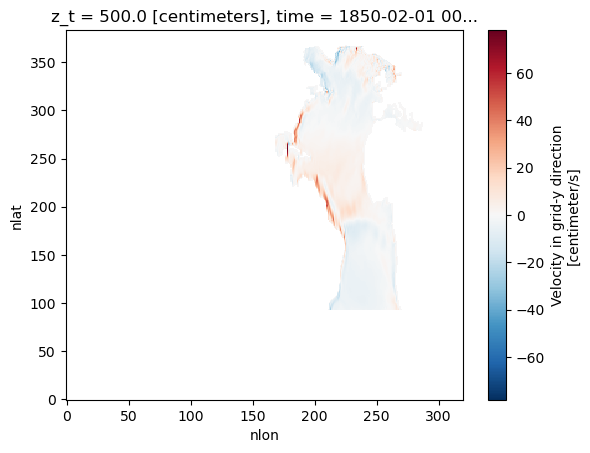

In [6]:
ds.VVEL.roll(nlon=-100).isel(time=0, z_t=0).where(moc_mask).plot()


In [8]:
def extract_member_id(filename):
    match = re.search(r'vvel_([^.]+(?:\.\d+)?)\.nc', filename)
    return match.group(1) if match else None

def standardise_time(ds):
    ds['time'] = xr.decode_cf(ds, use_cftime=True).time
    if isinstance(ds.time.values[0], cftime._cftime.DatetimeNoLeap):
        time_as_datetime64 = np.array([pd.Timestamp(str(dt)).to_datetime64() for dt in ds.time.values])
        ds['time'] = xr.DataArray(time_as_datetime64, dims='time')
    return ds

def calculate_dens2(temp_ds, salt_ds):
    CT = gsw.conversions.CT_from_pt(salt_ds['SALT'], temp_ds['TEMP'])
    dens2 = gsw.density.sigma2(salt_ds['SALT'], CT)
    dens2 = dens2.rename('SIGMA_2')
    return dens2

def load_and_process_dataset(file_path, mask):
    '''
    TIME REDUCED
    '''
    ds = xr.open_dataset(file_path, decode_times=False).isel(time=slice(0,3))
    ds = standardise_time(ds)
    try:
        processed_dataset = ds.roll(nlon=-100).where(mask)
    except (RuntimeError, IndexError) as e:
        print(f"Initial processing failed, loading step-by-step: {str(e)}")
        processed_dataset = handle_deprecated_data(ds, mask)
    print('process check')
    return processed_dataset

def handle_deprecated_data(ds, mask):
    total_time_steps = ds.dims['time']
    last_valid_data = None
    for t in range(total_time_steps):
        try:
            current_data = ds.isel(time=t).load()
            last_valid_data = current_data
        except RuntimeError as e:
            print(f"Error at timestep {t}: {str(e)}")
            if last_valid_data is not None:
                current_data = last_valid_data
            else:
                raise ValueError(f"No valid data at timestep {t}")
        if t == 0:
            combined_data = current_data
        else:
            combined_data = xr.concat([combined_data, current_data], dim='time')
    combined_data['time'] = np.arange(total_time_steps)
    result_dataset = combined_data.roll(nlon=-100).where(mask)
    return result_dataset

In [9]:
def density_overturning(vvel_dataset, density_dataset):
    density_bins = [12., 16., 20., 24., 28., 28.5, 29.2, 29.4, 29.6, 29.8, 30., 30.2, 30.4, 30.6, 30.8, 31., 31.2, 31.4, 31.6, 
                   31.8, 32., 32.2, 32.4, 32.6, 32.8, 33., 33.2, 33.4, 33.6, 33.8, 34., 34.2, 34.4, 34.6, 34.8, 35., 35.1, 
                   35.2, 35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36, 36.1, 36.15, 36.2, 36.25, 36.3, 36.35, 36.4, 36.42, 
                   36.44, 36.46, 36.48, 36.5, 36.52, 36.54, 36.56, 36.57, 36.58, 36.59, 36.6, 36.61, 36.62, 36.63, 36.64, 
                   36.65, 36.66, 36.67, 36.68, 36.69, 36.7, 36.71, 36.72, 36.73, 36.74, 36.75, 36.76, 36.78, 36.8, 36.82, 
                   36.84, 36.86, 36.88, 36.9, 36.92, 36.94, 36.96, 36.98, 37., 37.02, 37.04, 37.06, 37.08, 37.1, 37.12, 37.14, 
                   37.16, 37.18, 37.2, 37.25, 37.3, 37.35, 37.4, 37.45, 37.6, 37.7, 37.8, 37.9, 38., 39., 40., 41., 42.]
    max_overturning_series = []

    cell_thickness = vvel_dataset['dz']
    cell_width = vvel_dataset['DXU']
    
    for time_step in range(len(vvel_dataset.time)):
        try:
            # compute meridional flow rate for the specified latitude
            velocity = vvel_dataset['VVEL'].isel(time=time_step)
            flow_rate = velocity * cell_thickness * cell_width

            # compute meridional flow rate and for each density bin and integrate zonally
            density_at_time = density_dataset.isel(time=time_step)
            flow_rate_by_density = np.zeros(len(density_bins))
            for bin_index in range(len(density_bins) - 1):
                in_bin = (density_at_time >= density_bins[bin_index]) & (density_at_time < density_bins[bin_index + 1])
                flow_rate_by_density[bin_index] = flow_rate.where(in_bin).sum()

            # compute density overturning, reverse to integrate from high to low density
            density_overturning = np.cumsum(flow_rate_by_density)[::-1]
            max_overturning = np.max(density_overturning)
            max_overturning_series.append(max_overturning)
        except IndexError as e:
            print(f"Error occurred at time step: {time_step}")
            raise e
    
    max_overturning_dataarray = xr.DataArray(max_overturning_series, dims=["time"], coords={"time": vvel_dataset['time']})
    return max_overturning_dataarray  * 1e-12




'''
# THIS IS THE CODE FOR ALL ATLANTIC LATITUDES


def density_MOC(ds_vvel, da_dens):
    
    meridional_density = da_dens.mean(dim=['nlon'])
    cell_thickness = ds_vvel['dz']
    cell_width = ds_vvel['DXU']
    
    # prepare storage
    density_bins = None
    density_overturning_list = []
    
    for time_step in range(len(ds_vvel.time)):
        
        print('time step: ',time_step)
        
        density_overturning_at_time = []
        
        for latitude in range(len(ds_vvel.nlat)):

            # compute meridional flow rate for the specified latitude
            velocity = ds_vvel['VVEL'].isel(time=time_step, nlat=latitude)
            flow_rate = velocity * cell_thickness * cell_width

            # compute density bins
            density_at_time_and_lat = meridional_density.isel(time=time_step, nlat=latitude)
            densities = density_at_time_and_lat.values
            sorted_indices = np.argsort(densities)
            density_bins = densities[sorted_indices]

            # compute meridional flow rate and for each density bin and integrate zonally
            flow_rate_by_density = np.zeros(len(density_bins))
            for bin_index in range(len(density_bins) - 1):
                in_bin = (density_at_time_and_lat >= density_bins[bin_index]) & (density_at_time_and_lat < density_bins[bin_index + 1])
                flow_rate_by_density[bin_index] = flow_rate.where(in_bin).sum()


            # compute density overturning, reverse to integrate from high to low density
            density_overturning = np.cumsum(flow_rate_by_density)[::-1]
            density_overturning_at_time.append(density_overturning)

        density_overturning_list.append(density_overturning_at_time)

    print('last time step finished')
    # create dataset 
    density_overturning_array = np.array(density_overturning_list)

    return density_overturning_array, meridional_density
    
'''

"  \n    sigma_level = sorted_densities\n    min_lat = 250\n    max_lat = 365\n    smoc = []\n    for time_idx in range(len(ds_vvel.time)):\n        ds_vvel_time_step = ds_vvel.isel(time=time_idx)\n        ds_sigma_time_step = ds_sigma.isel(time=time_idx)\n        overturning = np.zeros([len(sigma_level), (max_lat - min_lat)])\n        for j in range(min_lat, max_lat):\n            sigma_transport = np.zeros(len(sigma_level))\n            v_transport = (ds_vvel_time_step.VVEL.isel(nlat=j) * ds_parameters.dz.isel(nlat=j) * ds_parameters.DXU.isel(nlat=j)).values\n            sigma_crossection = ds_sigma_time_step.SIGMA_2.isel(nlat=j).values\n            for i in range(len(sigma_level) - 1):\n                ind = np.where((sigma_crossection >= sigma_level[i]) & (sigma_crossection < sigma_level[i + 1]))\n                sigma_transport[i] = np.nansum(v_transport[ind])\n            overturning[:, j - min_lat] = np.cumsum(sigma_transport)[::-1]\n            overturning[:, j - min_lat] = ove

In [10]:
vvel_path = vvel_dir+vvel_file
temp_path = temp_dir+temp_file
salt_path = salt_dir+salt_file

In [11]:
temp_ds = load_and_process_dataset(temp_path, moc_mask)
salt_ds = load_and_process_dataset(salt_path, moc_mask)

process check
process check


In [12]:
sigma_da = calculate_dens2(temp_ds, salt_ds)
vvel_ds = load_and_process_dataset(vvel_path, moc_mask)

process check


In [ ]:
density_overturning_array, meridional_density = density_MOC(vvel_ds.isel(time=slice(0,3)), sigma_da.isel(time=slice(0,3)))

time step:  0
time step:  1


##Make daatset

In [ ]:
density_overturning_array

In [ ]:
meridional_density

In [ ]:
vvel_ds

In [ ]:
    ds_results = xr.Dataset(
        {
            'm_DENS': (['time', 'nlat', 'depth'], meridional_density),
            'sMOC': (['time', 'nlat', 'density_bin'], density_overturning_array)
        },
        coords={
            'time': ds_vvel.time,
            'nlat': ds_vvel.nlat,
            'depth': ds_vvel['depth'],
            'density_bin': density_bins_unique[:-1]
        }
    )



In [ ]:
total_members = len(os.listdir(temp_dir))
processed_count = 0

for file in os.listdir(vvel_dir):
    member_id = extract_member_id(file)
    vvel_path = os.path.join(vvel_dir, file)
    temp_path = os.path.join(temp_dir, f'temp_{member_id}.nc')
    salt_path = os.path.join(salt_dir, f'salt_{member_id}.nc')
 
    temp_ds = load_and_process_dataset(temp_path, moc_mask)
    salt_ds = load_and_process_dataset(salt_path, moc_mask)
    sigma_ds = calculate_dens2(temp_ds, salt_ds)
    vvel_ds = load_and_process_dataset(vvel_path, moc_mask)
    
    max_overturning_series = density_overturning(vvel_ds, sigma_ds, sel_nlat)
    max_overturning_series.to_netcdf(os.path.join(output_dir, f'smoc_{member_id}.nc'))

    temp_ds.close()
    salt_ds.close()
    sigma_ds.close()
    vvel_ds.close()
    max_overturning_series.close()

    del temp_ds, salt_ds, sigma_ds, vvel_ds, max_overturning_series
    gc.collect()

    print(f'{member_id} saved')
    
print('')
print('computation complete')
print('')